# Change Point Identification
- ported from python
- to detect change points in the time series of log(var) of gh500 in the North Atlantic
- use monthly data for simplicity and because spatial aggregation makes daily scale inconsistent

In [1]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")

options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.1; sf_use_s2() is TRUE

Lade nötiges Paket: maps


Attache Paket: ‘rnaturalearthdata’


Das folgende Objekt ist maskiert ‘package:rnaturalearth’:

    countries110


Lade nötiges Paket: abind


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Attache Paket: ‘purrr’


Das folgende Objekt ist maskiert ‘package:maps’:

    map



Attache Paket: ‘lubridate’


Das folgende Objekt ist maskiert ‘package:cowplot’:

    stamp


Die folgenden Objekte sind maskiert von ‘package:base’:

    date, intersect, setdiff, union



Attache Paket: ‘data.table’


Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Das folgende Objekt ist maskiert ‘package:purrr’:

    transpose


Die folgenden Objekte sind maskiert von

## Data preprocessing

In [2]:
# List netCDF files matching the pattern "spread_*.nc"
spread_files <- list.files(
    path = DATA_DIR,
    pattern = "^spread_.*\\.nc$",
    full.names = TRUE
)

spread_files <- sort(spread_files)
extract_year <- function(file_name) {
    # Extract the year (digits after last '_' and before '.nc')
    base <- basename(file_name)
    m <- regexpr("_(\\d+)\\.nc$", base, perl = TRUE)
    year_str <- regmatches(base, m)
    year_str <- sub("^_", "", year_str)
    year_str <- sub("\\.nc$", "", year_str)
    as.integer(year_str)
}

years <- sapply(spread_files, extract_year)


In [3]:
# Compute monthly averages for each file
monthly_averages <- lapply(spread_files, calculate_monthly_averages)

# Combine the per-file datasets into one data frame
combined_dataset <- combine_datasets(monthly_averages, years) %>% mutate(
  log_variance = log(avg_z),
  sin_mon = sin(2 * pi * month / 12),
  cos_mon = cos(2 * pi * month / 12)
)

combined_dataset$date <- as.Date(with(
  combined_dataset,
  paste(year, month, "01", sep = "-")
))

combined_dataset$mon_no <-
  (year(combined_dataset$date) - 1940) * 12 + (month(combined_dataset$date) - 1)
str(combined_dataset)


tibble [1,019 × 8] (S3: tbl_df/tbl/data.frame)
 $ month       : num [1:1019] 1 2 3 4 5 6 7 8 9 10 ...
 $ avg_z       : num [1:1019] 67186 54663 45525 56765 46970 ...
 $ year        : int [1:1019] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ log_variance: num [1:1019] 11.1 10.9 10.7 10.9 10.8 ...
 $ sin_mon     : num [1:1019] 0.5 0.866 1 0.866 0.5 ...
 $ cos_mon     : num [1:1019] 8.66e-01 5.00e-01 6.12e-17 -5.00e-01 -8.66e-01 ...
 $ date        : Date[1:1019], format: "1940-01-01" "1940-02-01" ...
 $ mon_no      : num [1:1019] 0 1 2 3 4 5 6 7 8 9 ...


# Look at Seasonality of Dataset

**How exactly does the seasonal cycle in the dataset look? And how does it change across change points?**

To find change points and estimate parameters, used [mcp](https://lindeloev.github.io/mcp/index.html); but it didnt work that well and does not permit multiple predictors. So stick with strucchange

1. Find change points assuming annual slope, offset and variance varies 
    1. With the seasonal cycle not varying
    2. With the seasonal cycle varying
3. Visualize
    1. box-whiskers plot for each month for each segment along with a best fit sin-cos
    2. scatter plot with x: amplitude, y: phase (month of maximum) along with uncertainty for annual and segments

In [4]:
ordered_cp_df <- function(bp_est_monthly, data) {
    # Get summary and confidence intervals
    bp_summary <- summary(bp_est_monthly)
    ci_bp_monthly <- confint(bp_est_monthly,
        vcov = sandwich::NeweyWest,
        level = 0.95
    )

    # Extract breakpoints
    cp_indices <- bp_summary$breakpoints[length(bp_est_monthly$breakpoints), ]

    # Compute NA counts for ordering and filter non-NA values
    na_counts <- colSums(is.na(bp_summary$breakpoints))
    valid_indices <- !is.na(cp_indices)
    ordered_indices <- order(na_counts[valid_indices], decreasing = FALSE)
    cp_indices_ordered <- cp_indices[valid_indices][ordered_indices]

    # Convert indices to dates
    matched_indices <- match(cp_indices_ordered, ci_bp_monthly$confint[, 2])
    cp_dates <- data$date[cp_indices_ordered]
    cp_dates_lower <- data$date[ci_bp_monthly$confint[matched_indices, 1]]
    cp_dates_upper <- data$date[ci_bp_monthly$confint[matched_indices, 3]]

    # Create ordered change point data frame
    cp_df <- data.frame(
        cp_date = cp_dates,
        cp_date_lower = cp_dates_lower,
        cp_date_upper = cp_dates_upper,
        cp_no = seq_along(cp_dates) # Identifier for the change points
    )

    return(cp_df)
}



	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = ar_fit_glob, het.reg = TRUE, 
    het.err = TRUE, vcov. = vcovHC, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   151         152    153
2   303         305    325
3   468         471    472
4   686         687    688
5   838         839    841

Corresponding to breakdates:
      2.5 % breakpoints    97.5 %
1 0.1481845   0.1491658 0.1501472
2 0.2973503   0.2993131 0.3189401
3 0.4592738   0.4622179 0.4631992
4 0.6732090   0.6741904 0.6751717
5 0.8223749   0.8233562 0.8253189


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1952-08-01,1952-07-01,1952-10-01,1
1979-03-01,1976-11-01,1979-07-01,2
1997-03-01,1997-01-01,1998-01-01,3
2009-11-01,2009-10-01,2010-08-01,4
1965-05-01,1964-08-01,1973-09-01,5


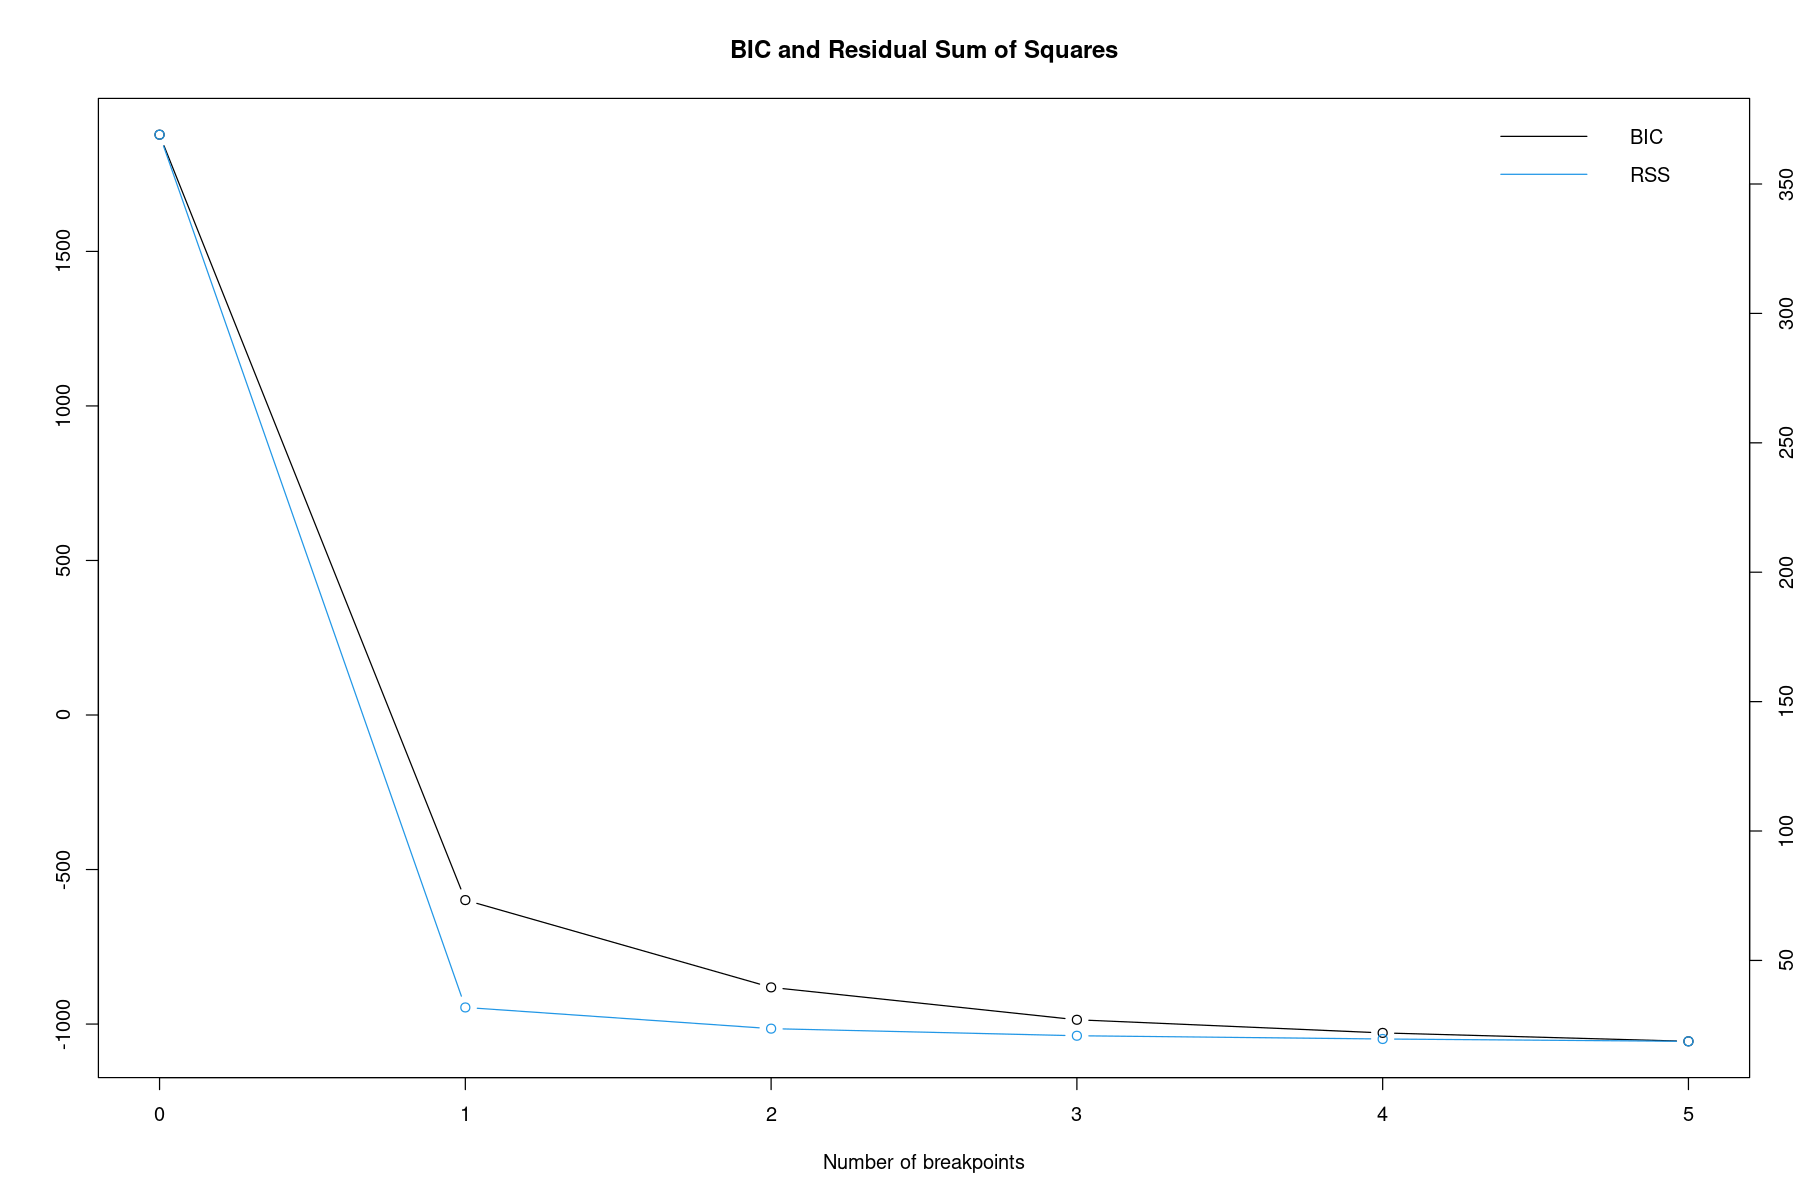

In [5]:
glob_ar_mod <- nlme::gls(
    log_variance ~ 1,
    data        = combined_dataset,
    correlation = corAR1(form = ~mon_no)
)

filtered_df <- combined_dataset %>%
    mutate(ar_filtered = residuals(glob_ar_mod))


ar_fit_glob <- breakpoints(
    ar_filtered ~ year,
    data     = filtered_df,
    h        = .15,
    breaks   = NULL
)
par(bg = "white")
plot(ar_fit_glob)
print(confint(ar_fit_glob,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = vcovHC
))

cp_df <- ordered_cp_df(ar_fit_glob, combined_dataset)
cp_df


In [6]:
combined_dataset$segment_no_seas <- breakfactor(ar_fit_glob)


# Fit the segmented linear model with segment-specific predictors
lmod_monthly_no_seas <- nlme::gls(
    log_variance ~ segment_no_seas +
        segment_no_seas:year - 1,
    data = combined_dataset,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

# Summarize the segmented model results
summary(lmod_monthly_no_seas)


Generalized least squares fit by REML
  Model: log_variance ~ segment_no_seas + segment_no_seas:year - 1 
  Data: combined_dataset 
        AIC       BIC   logLik
  -2195.464 -2102.084 1116.732

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
      Phi 
0.7326105 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.5750666 0.4992213 0.3958200 0.3437048 0.3038822 

Coefficients:
                                Value Std.Error    t-value p-value
segment_no_seassegment1      576.5982 24.998723  23.065106  0.0000
segment_no_seassegment2      101.2943 14.160225   7.153436  0.0000
segment_no_seassegment3       72.0071 11.059625   6.510812  0.0000
segment_no_seassegment4       40.4311  6.094227   6.634328  0.0000
segment_no_seassegment5      117.1572  8.839739  13.253472  0.0000
segment_no_seassegment6    

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


pdf 
  2

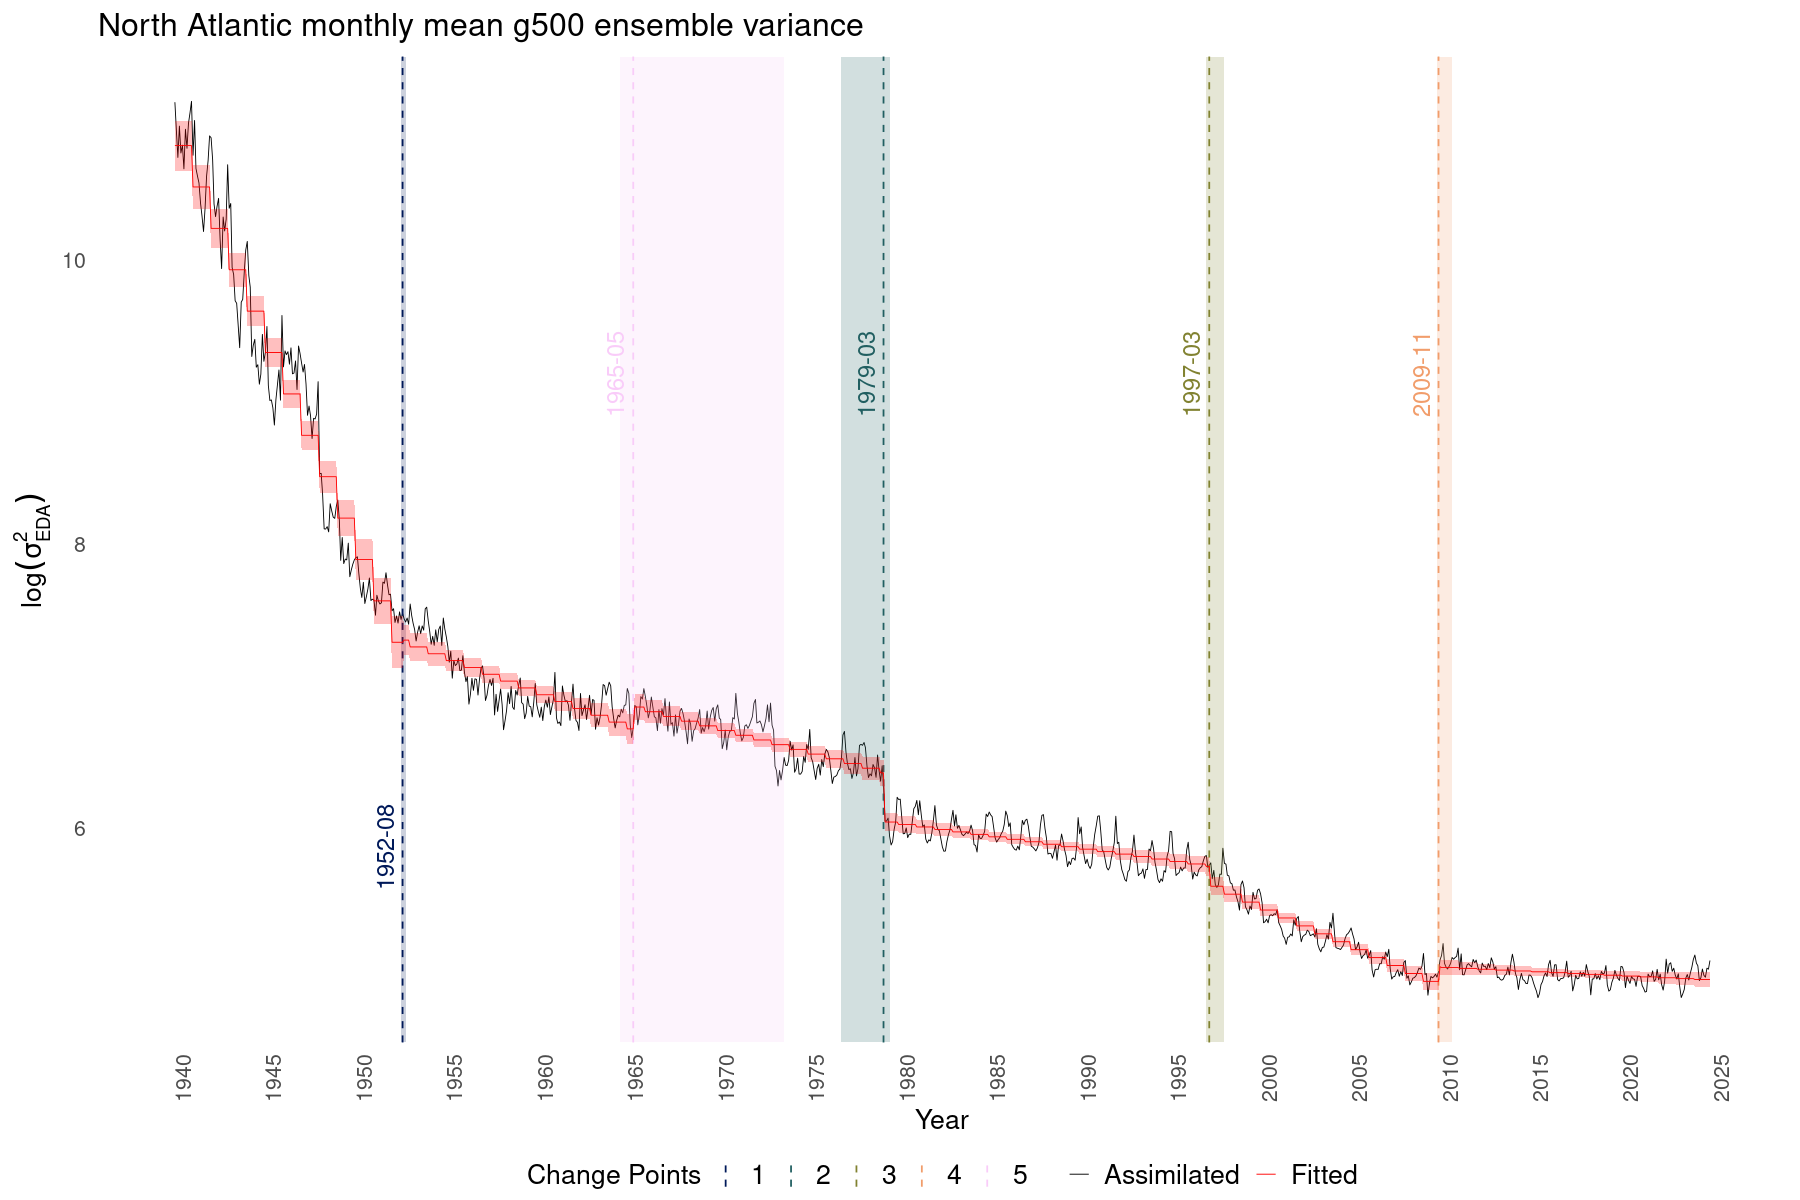

In [7]:
p <- plot_change_points(
    data = combined_dataset,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)

fitted_layers <- add_fitted_line_ci(lmod_monthly_no_seas, combined_dataset)
for (layer in fitted_layers) {
    p <- p + layer
}
p + THEME_PUB_LARGE
save_plot(p, "ChangePointsNoSeasLarge.pdf", width = 9.5, height = 4.25)


In [8]:
seasonal_model <- nlme::gls(
    log_variance ~ year:segment_no_seas + segment_no_seas +
        sin_mon + cos_mon - 1,
    data = combined_dataset,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

summary(seasonal_model)


Generalized least squares fit by REML
  Model: log_variance ~ year:segment_no_seas + segment_no_seas + sin_mon +      cos_mon - 1 
  Data: combined_dataset 
        AIC       BIC   logLik
  -2307.425 -2204.258 1174.713

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
      Phi 
0.6902608 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.5907717 0.4830370 0.3400105 0.3340796 0.3205124 

Coefficients:
                                Value Std.Error    t-value p-value
segment_no_seassegment1      579.4098 21.109954  27.447234  0.0000
segment_no_seassegment2      103.0800 12.309677   8.373903  0.0000
segment_no_seassegment3       75.3253  9.039303   8.333088  0.0000
segment_no_seassegment4       42.7408  4.401924   9.709572  0.0000
segment_no_seassegment5      120.1159  7.257350  16.550930  0.0000
se

In [9]:
trend_only_df <- combined_dataset %>%
    mutate(
        sin_mon = 0,
        cos_mon = 0
    )

# Now predict() this
combined_dataset <- combined_dataset %>%
    mutate(
        fitted_trend_only = predict(seasonal_model, newdata = trend_only_df)
    )

# The “deseasonalized” response is
#    y_i^(ds) = log_variance_i - fitted_trend_i
combined_dataset <- combined_dataset %>%
    mutate(
        y_seas = log_variance - fitted_trend_only
    )

# ── 4) Extract the seasonal‐term coefficients + 2×2 covariance ───────────────────
coefs_all <- coef(seasonal_model)
beta_sin <- coefs_all["sin_mon"]
beta_cos <- coefs_all["cos_mon"]

V_all <- vcov(seasonal_model)
V_seas <- V_all[c("sin_mon", "cos_mon"), c("sin_mon", "cos_mon")]

df_resid <- nrow(combined_dataset) - length(coef(seasonal_model))

# ── 5) Build a 12‐row data.frame giving month = 1…12, sin_mon, cos_mon ─────────
new_season <- tibble(
    month = 1:12
) %>%
    mutate(
        sin_mon = sin(2 * pi * (month / 12)),
        cos_mon = cos(2 * pi * (month / 12))
    ) %>%
    rowwise() %>%
    mutate(
        # point‐estimate of the seasonal fit
        fit = beta_sin * sin_mon + beta_cos * cos_mon,

        # its standard error:  sqrt([s c] %*% V_seas %*% [s; c])
        se = sqrt(
            c(sin_mon, cos_mon) %*% V_seas %*% matrix(c(sin_mon, cos_mon), ncol = 1)
        )
    ) %>%
    ungroup() %>%
    mutate(
        lwr = fit - qt(0.975, df = df_resid) * se,
        upr = fit + qt(0.975, df = df_resid) * se
    )


pdf 
  2

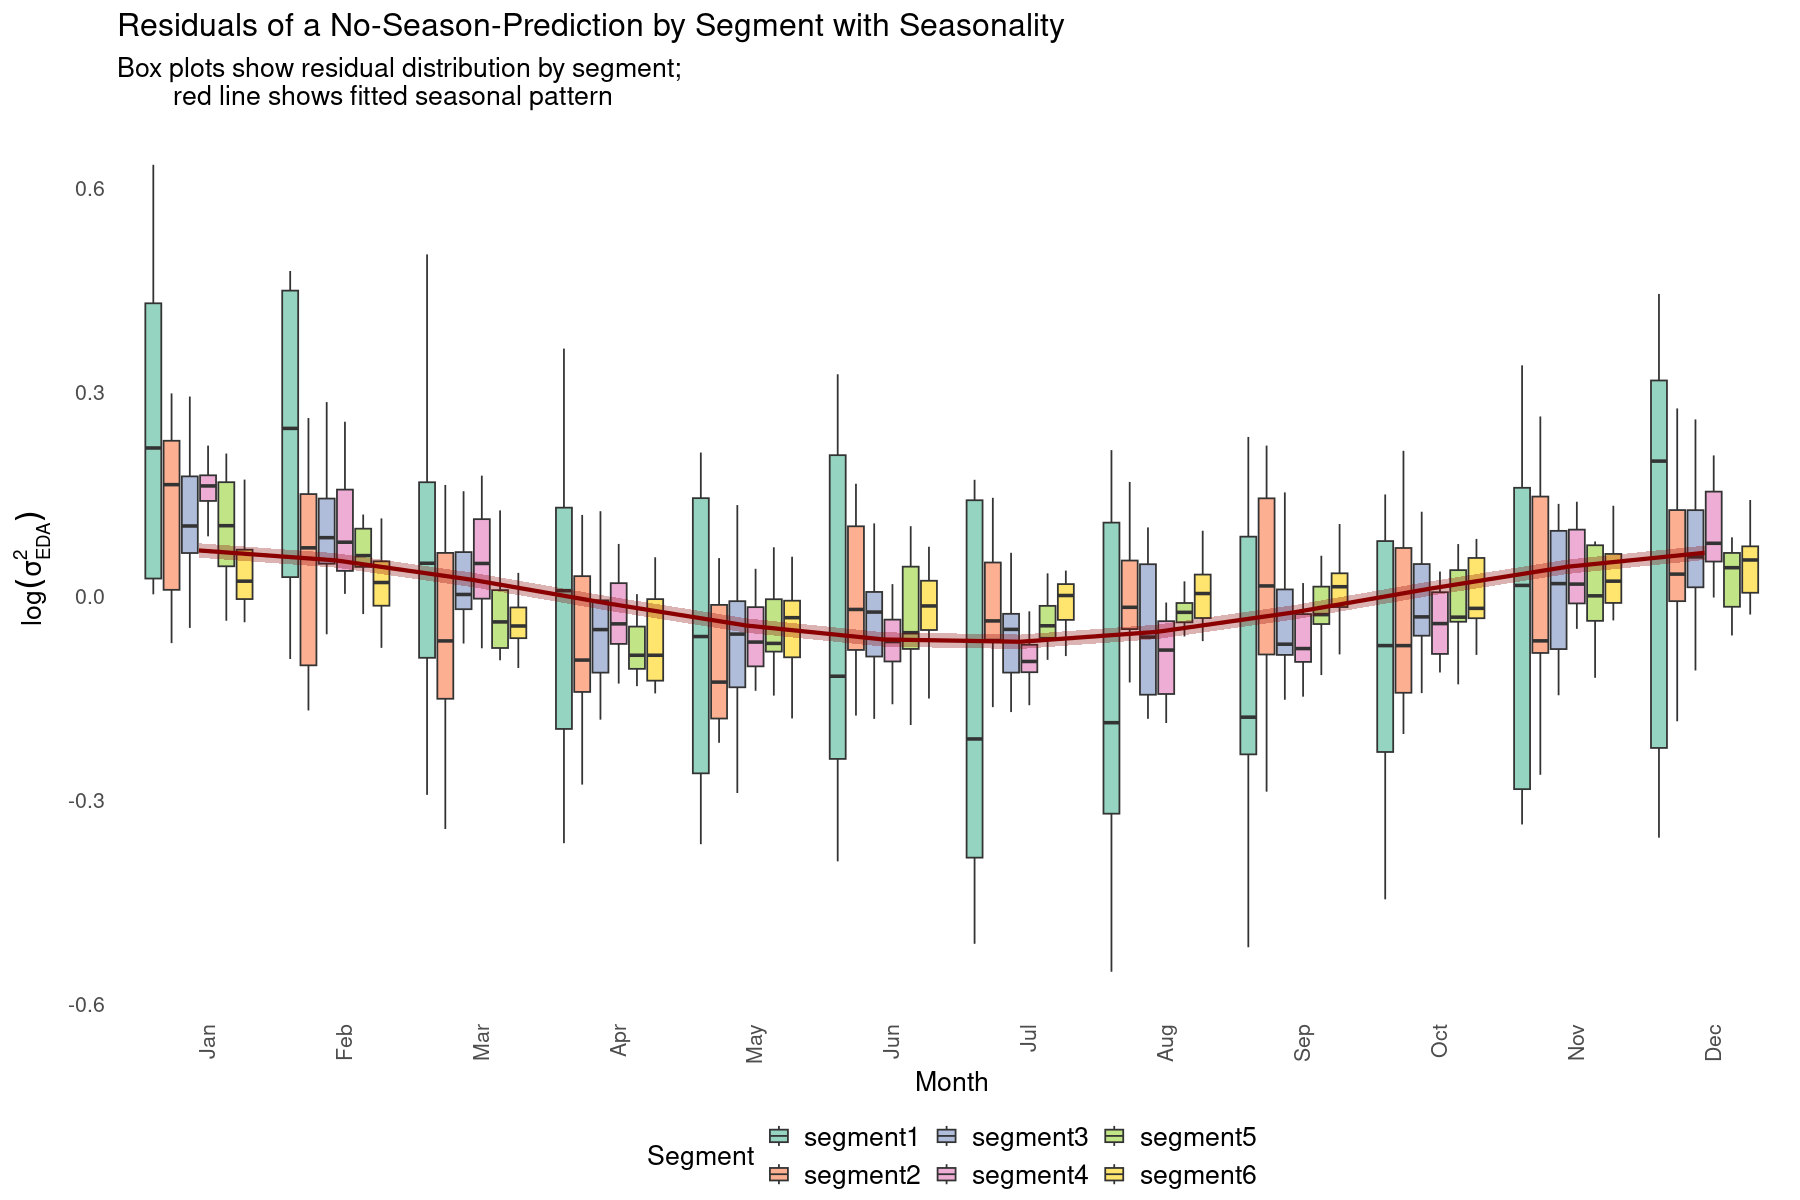

In [10]:
p <- ggplot(combined_dataset, aes(x = factor(month), fill = segment_no_seas)) +
    # Box plots for residuals by month and segment
    geom_boxplot(aes(y = y_seas),
        alpha = 0.7,
        outlier.shape = NA, # Remove outliers
        width = 0.7, # Make boxes narrower
        position = position_dodge(width = 0.8) # Space out the boxes
    ) +
    # Use a color palette that works well with 6 segments
    scale_fill_brewer(type = "qual", palette = "Set2", name = "Segment") +
    geom_ribbon(
        data = new_season,
        aes(x = month, ymin = lwr, ymax = upr, group = 1, fill = NULL),
        alpha = 0.3,
        fill = "darkred",
        inherit.aes = FALSE
    ) +
    # Add seasonal trend line
    geom_line(
        data = new_season,
        aes(x = month, y = fit, group = 1, fill = NULL),
        color = "darkred",
        size = 1.2,
        linetype = "solid",
        inherit.aes = FALSE
    ) +
    # Customize the plot
    scale_x_discrete(labels = month.abb) +
    labs(
        title = "Residuals of a No-Season-Prediction by Segment with Seasonality",
        subtitle = "Box plots show residual distribution by segment;
        red line shows fitted seasonal pattern",
        x = "Month",
        y = TeX("$\\log(\\sigma^{2}_{EDA})$")
    ) +
    THEME_PUB_LARGE

# Display the plot
print(p)
save_plot(p, "MonthlyResSingleSeason.pdf", width = 9, height = 5)


**The above shows that it is crucial to allow the seasonal cycle to vary between segments! See also the last section in this notebook**

In [11]:
p <- ggplot(combined_dataset, aes(x = factor(month))) +
    # Box plots for residuals by month
    geom_boxplot(aes(y = residuals_no_seas),
        alpha = 0.7,
        fill = "lightblue",
        outlier.color = "darkblue",
        outlier.alpha = 0.6
    ) +
    geom_ribbon(
        data = seasonal_df,
        aes(x = month, ymin = lwr, ymax = upr, group = 1),
        alpha = 0.3,
        fill = "darkred"
    ) +

    # Add seasonal trend line
    geom_line(
        data = seasonal_df,
        aes(x = month, y = fit, group = 1),
        color = "darkred",
        size = 1.2,
        linetype = "solid"
    ) +
    # Customize the plot
    scale_x_discrete(labels = month.abb) +
    labs(
        title = "Monthly Distribution of Log-Variance Residuals with Seasonal Trend",
        subtitle = "Box plots show residual distribution; red line shows fitted seasonal pattern",
        x = "Month",
        y = "Residuals (Log-Variance)"
    ) +
    THEME_PUB_LARGE
# Display the plot
print(p)


ERROR: Error in fortify(data): Objekt 'seasonal_df' nicht gefunden


## Binary Segmentation
- legacy code because breakpoints in regressions is more suitable

In [ ]:
flattened_data <- combined_dataset$avg_z
log_data <- log(flattened_data)

#---------------- Change Point Detection and Plotting ------------------------
max_cp_vec <- 1:4

# Prepare an empty data frame to accumulate change point info:
# cp_index: index in the time series
# cp_date: the corresponding date
# max_cp: the hierarchical level (i.e. the iteration when first found)
cp_df <- data.frame(
    cp_index = integer(),
    cp_date = as.Date(character()),
    max_cp = integer(),
    stringsAsFactors = FALSE
)

# Loop over each max_cp value and detect change points hierarchically.
for (i in seq_along(max_cp_vec)) {
    max_cp <- max_cp_vec[i]
    cpt_obj <- cpt.mean(log_data,
        method = "BinSeg", Q = max_cp,
        class = TRUE
    )
    # cpts() returns the indices of the change points (including the final index)
    cps <- cpts(cpt_obj)
    cps <- cps[cps < length(flattened_data)]

    # Save only newly found change points
    new_cps <- cps[!cps %in% cp_df$cp_index]

    if (length(new_cps) > 0) {
        for (cp in new_cps) {
            cp_df <- rbind(
                cp_df,
                data.frame(
                    cp_index = cp,
                    cp_date = combined_dataset$date[cp],
                    max_cp = max_cp,
                    stringsAsFactors = FALSE
                )
            )
        }
        cat(
            "Max change points:", max_cp,
            "-> New cp detected at indices:", paste(new_cps, collapse = ", "),
            "which correspond to dates:",
            paste(as.character(combined_dataset$date[new_cps]),
                collapse = ", "
            ), "\n"
        )
    } else {
        cat(
            "Max change points:", max_cp,
            "-> No new change points detected.\n"
        )
    }
}

#--- Build the base plot using actual date values on the x-axis ---------------
p <- ggplot(data = combined_dataset, aes(x = date, y = avg_z)) +
    geom_line() +
    scale_y_log10() +
    labs(
        x = "Time", y = "Log(Var)",
        title = "Original Data with Detected Change Points",
        color = "Hierarchy"
    ) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    THEME_PUB +
    scale_x_date(date_breaks = "5 year", date_labels = "%Y") +
    scale_color_scico_d(palette = "batlow") # discrete colour scale

#--- Add vertical lines and annotations for change points --------------------
if (nrow(cp_df) > 0) {
    y_pos <- max(combined_dataset$avg_z, na.rm = TRUE) * .7
    p <- p +
        geom_vline(
            data = cp_df, aes(
                xintercept = cp_date,
                color = factor(max_cp)
            ),
            linetype = "dashed", linewidth = 1
        ) +
        geom_text(
            data = cp_df, aes(
                x = cp_date, y = y_pos,
                label = format(cp_date, "%Y-%m"),
                color = factor(max_cp)
            ),
            angle = 90, vjust = -0.5, hjust = 0, size = 5, show.legend = FALSE
        ) +
        guides(color = guide_legend(
            override.aes = list(
                shape = NA,
                linetype = "dashed"
            )
        )) +
        theme(
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 18),
            legend.key.size = unit(2, "lines")
        )
}

#--- Display the plot ---------------------------------------------------------
print(p)

#--- Print out the exact time values (and indices) identified ----------------
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


In [ ]:
max_cp_vec <- 1:4

# Detect change points
cp_df <- detect_change_points(
    log_data,
    combined_dataset$date,
    max_cp_vec
)

# Create the plot (THEME_PUB can be passed if defined)
p <- plot_change_points(combined_dataset, cp_df, theme_pub = THEME_PUB)

# Display the plot
print(p)

# Print the detected change points
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


## Multiple structural change models (Bai & Perron, 2003)
**Challenge:** Choose either max number of breakpoints or minimum segment size?

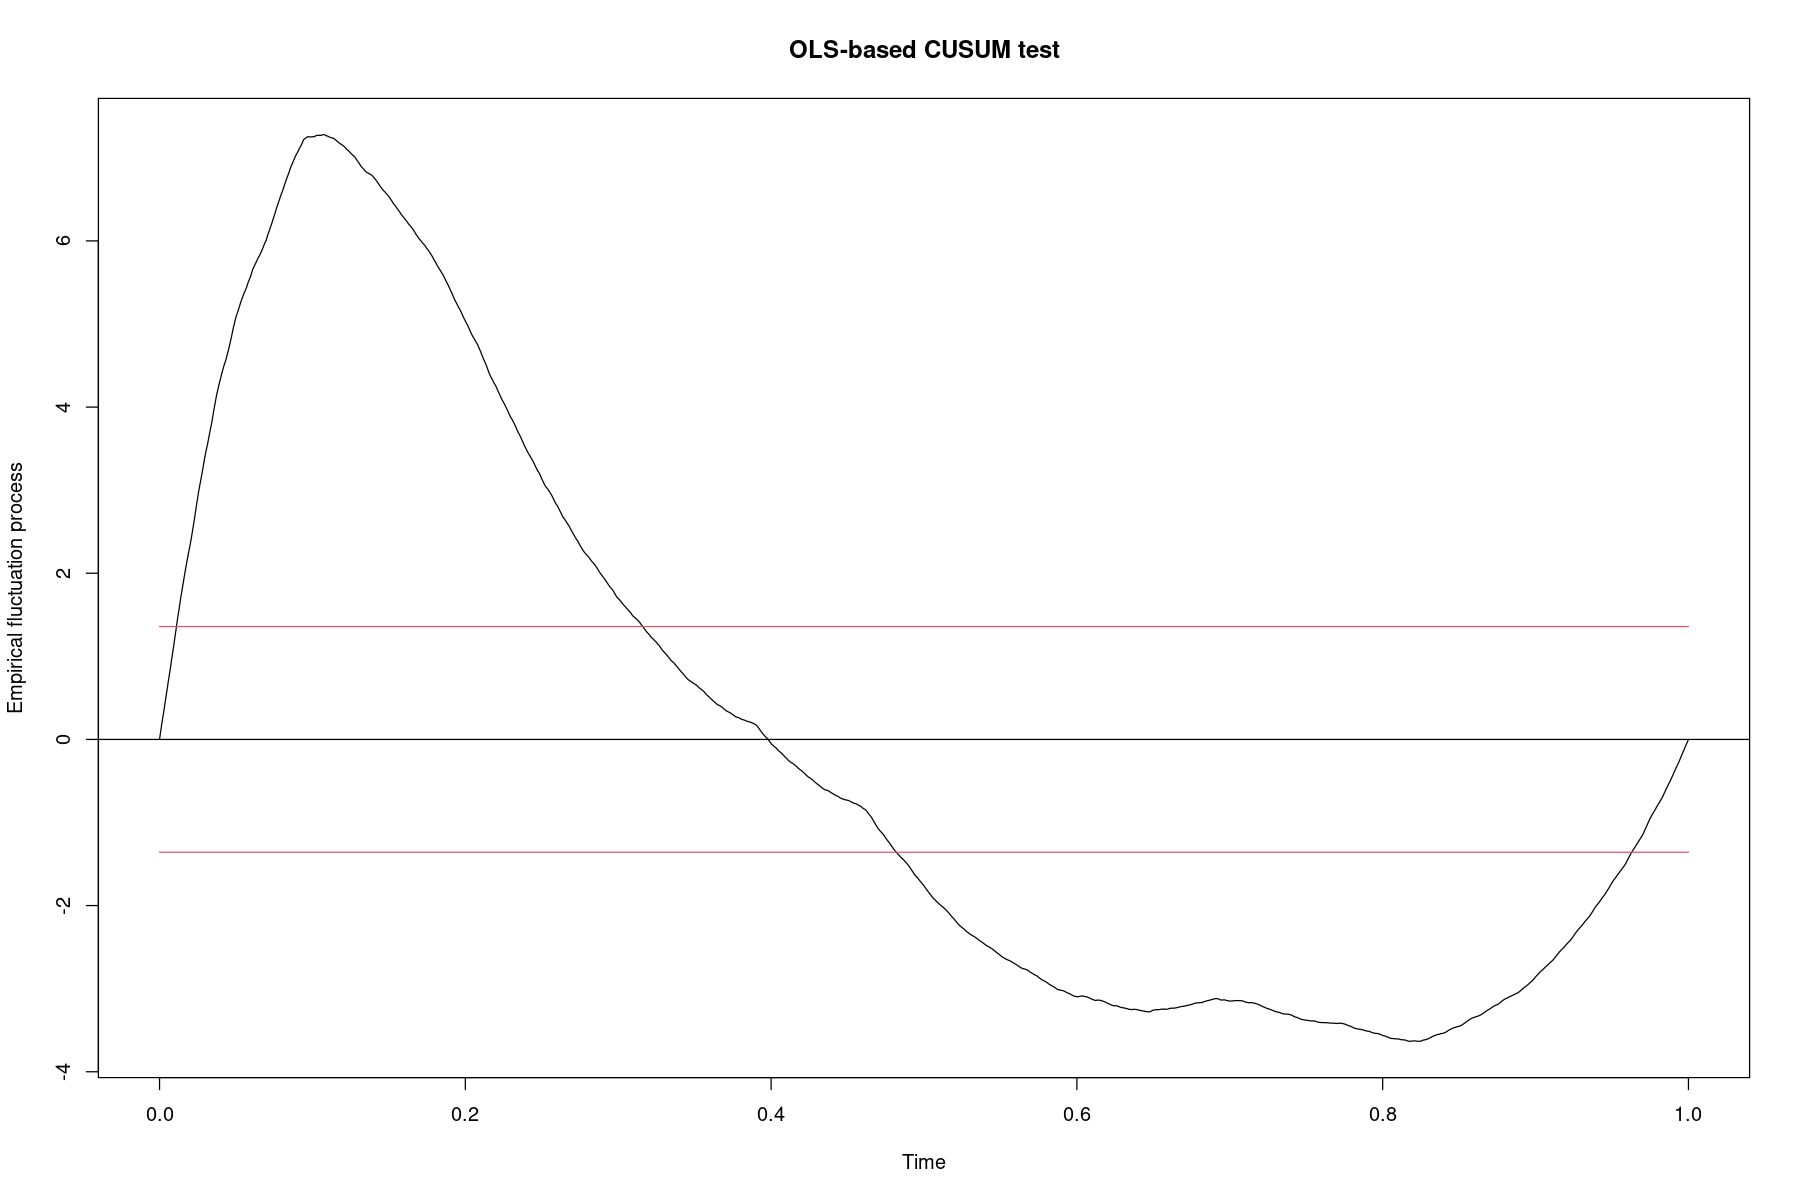

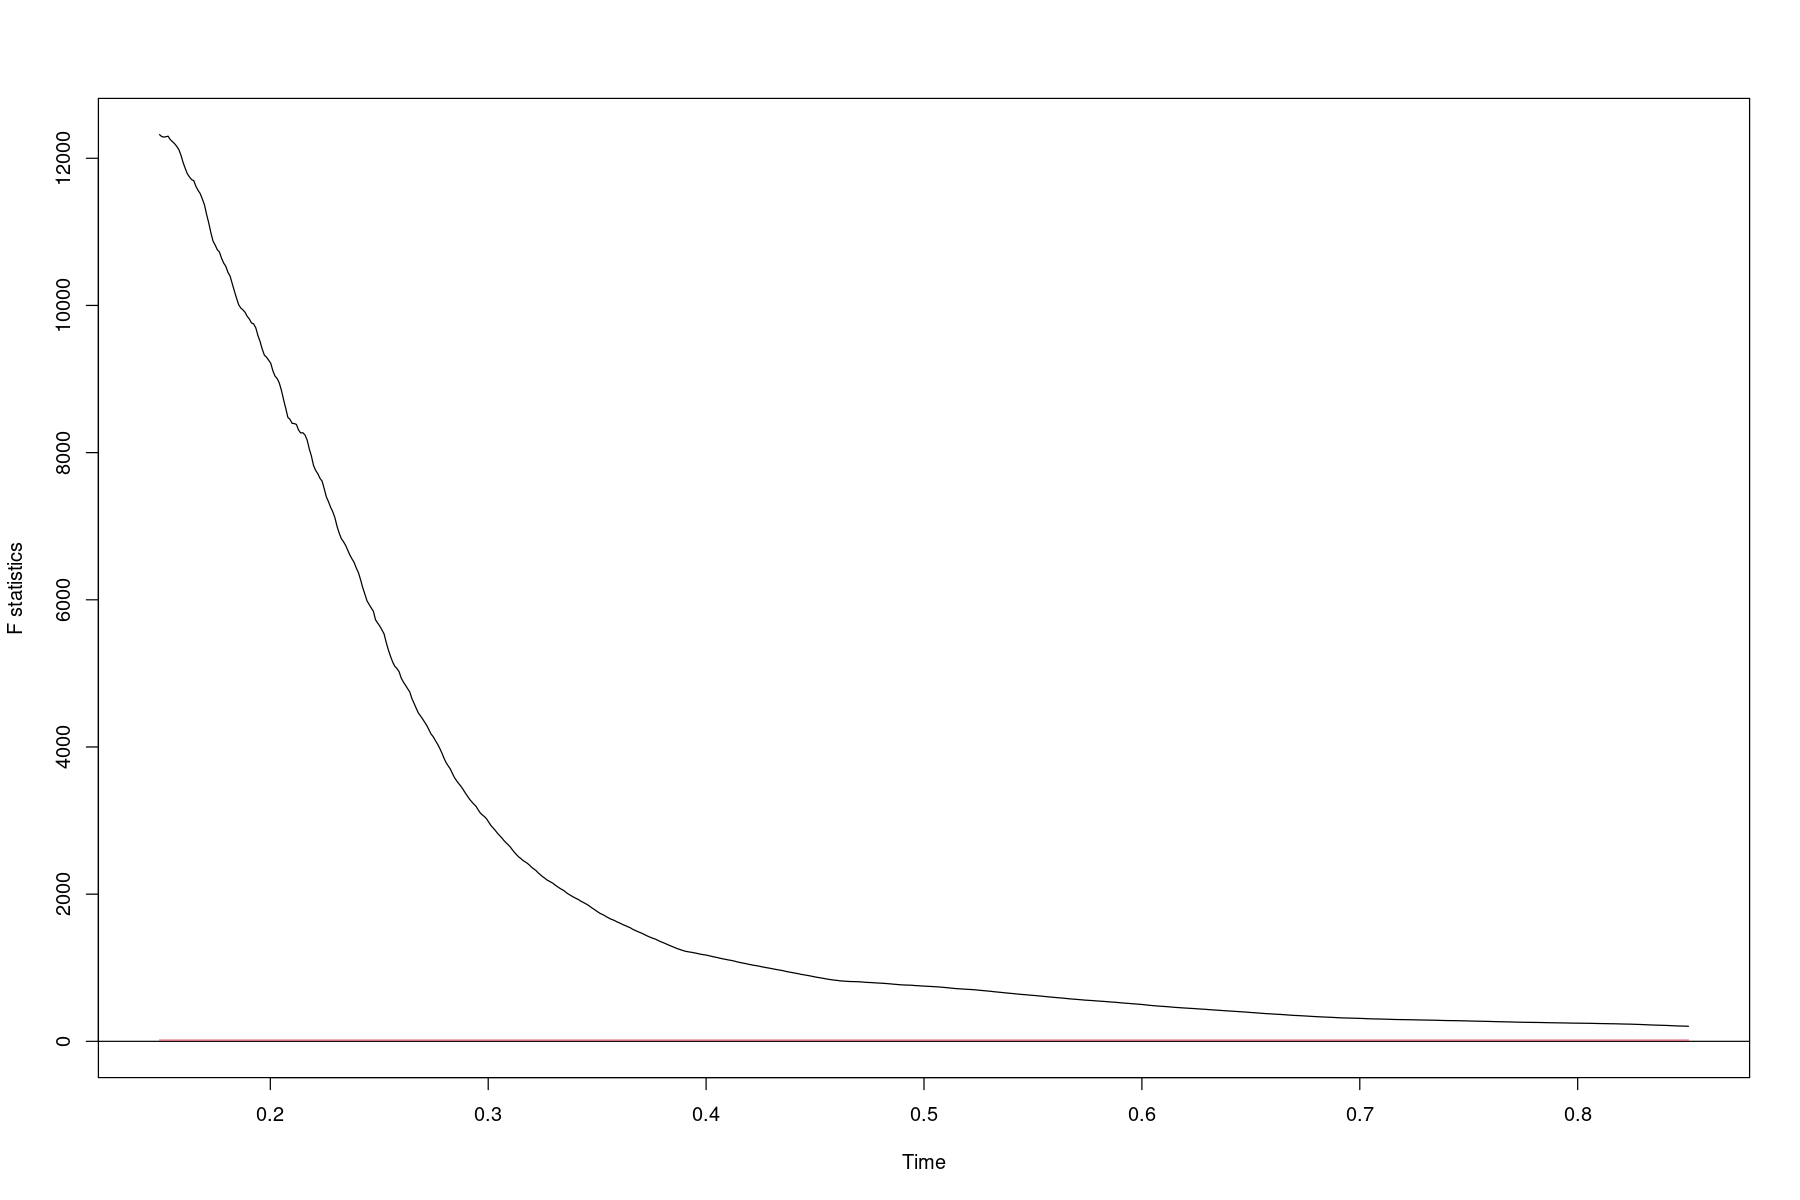

In [12]:
par(bg = "white")

ocus <- efp(
    formula = ar_filtered ~ year + sin_mon + cos_mon,
    data = filtered_df,
    type = "OLS-CUSUM"
)

plot(ocus)

fs <- Fstats(ar_filtered ~ year + sin_mon + cos_mon, data = filtered_df)
plot(fs)


pdf 
  2


	 Optimal 6-segment partition: 

Call:
breakpoints.formula(formula = ar_filtered ~ year + sin_mon + 
    cos_mon, h = 0.15, breaks = NULL, data = filtered_df)

Breakpoints at observation number:
152 305 471 666 821 

Corresponding to breakdates:
0.1491658 0.2993131 0.4622179 0.6535819 0.8056919 

	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = bp_est_monthly, het.reg = TRUE, 
    het.err = TRUE, vcov. = vcovHC, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   151         152    153
2   304         305    321
3   470         471    472
4   665         666    667
5   820         821    822

Corresponding to breakdates:
      2.5 % breakpoints    97.5 %
1 0.1481845   0.1491658 0.1501472
2 0.2983317   0.2993131 0.3150147
3 0.4612365   0.4622179 0.4631992
4 0.6526006   0.6535819 0.6545633
5 0.8047105   0.8056919 0.8066732


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1952-08-01,1952-07-01,1952-09-01,1
1979-03-01,1978-11-01,1979-06-01,2
1995-06-01,1995-04-01,1995-07-01,3
2008-05-01,2008-04-01,2008-07-01,4
1965-05-01,1965-01-01,1970-10-01,5


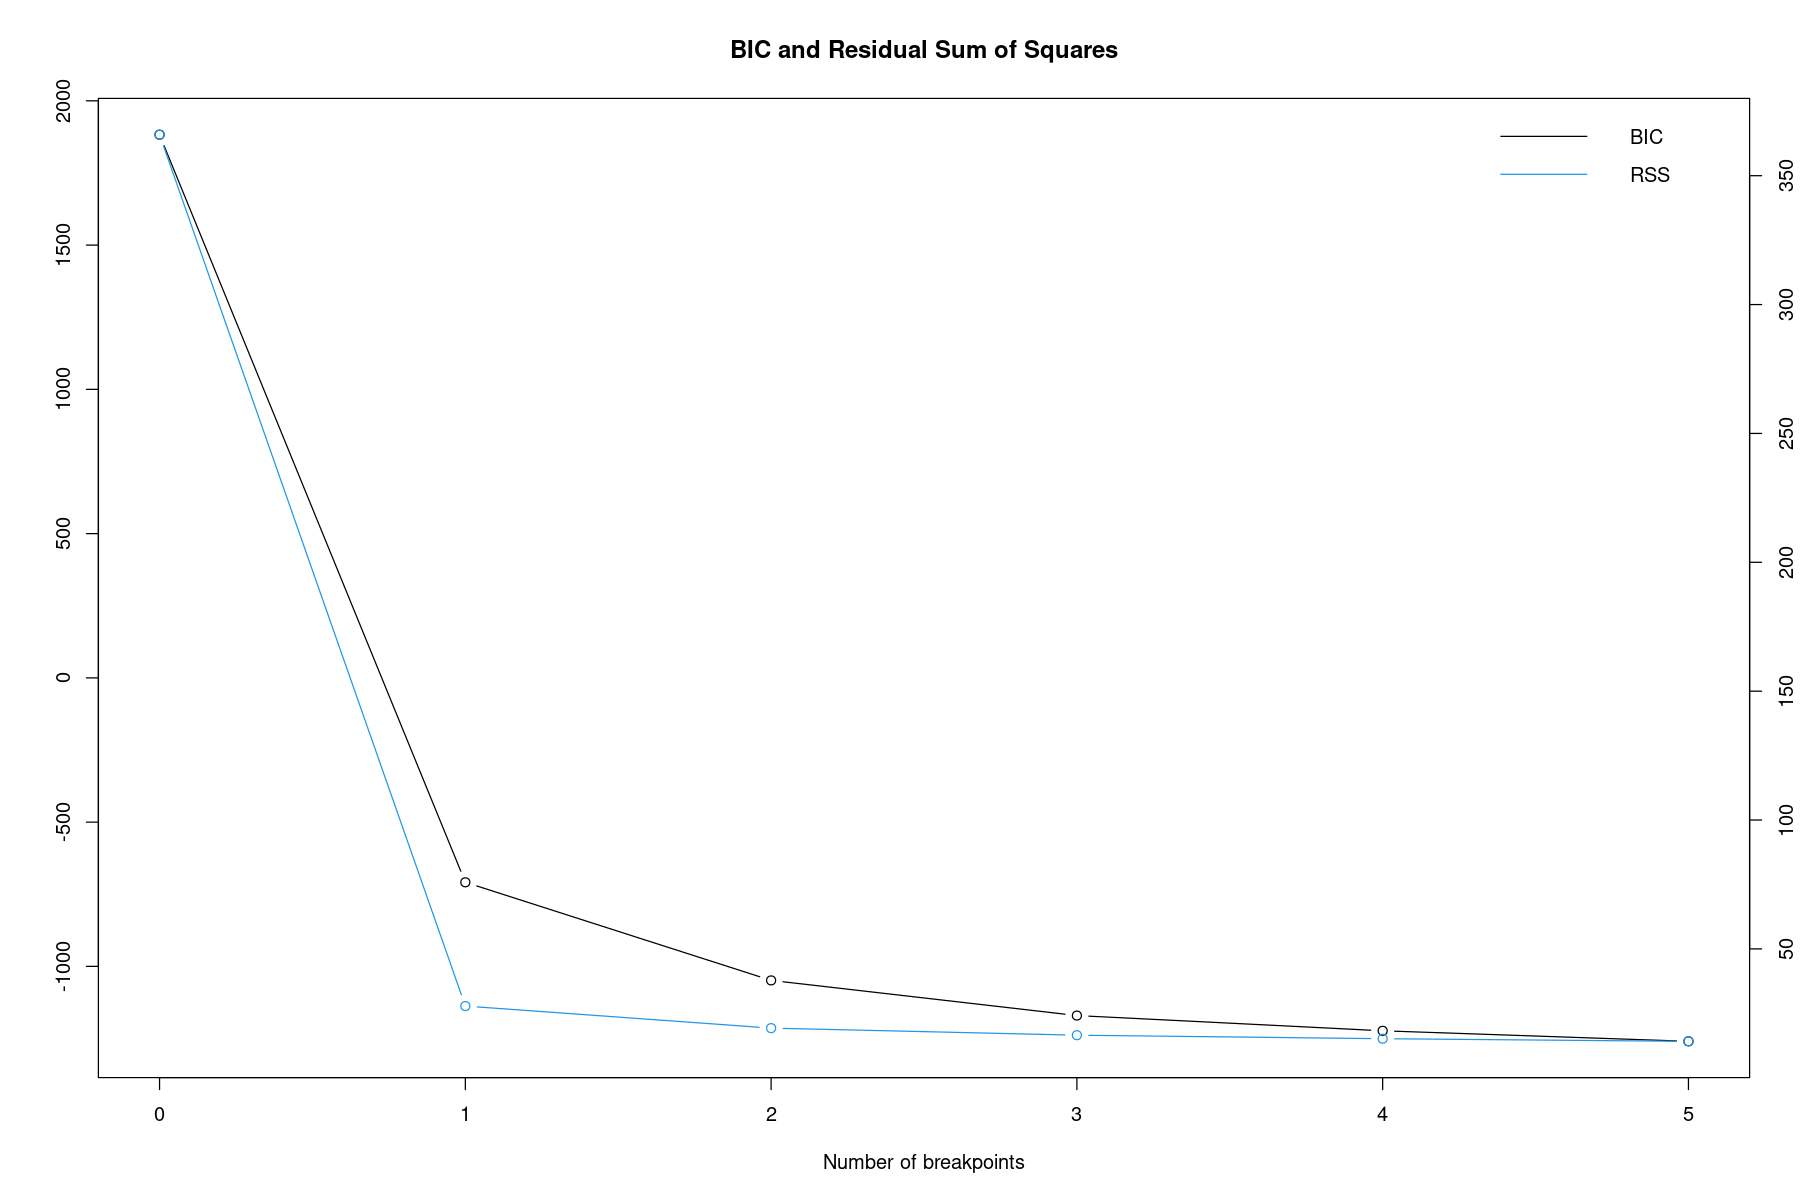

In [13]:
# Estimate breakpoints with seasonal predictors differing in each segment
# Control for AR(1)
bp_est_monthly <- breakpoints(ar_filtered ~ year + sin_mon + cos_mon,
    data = filtered_df,
    h = .15,
    breaks = NULL
)
par(bg = "white")
plot(bp_est_monthly)
pdf(paste0(OUT_DIR, "BIC_breakpoints.pdf"), width = 4, height = 3)
plot(bp_est_monthly)
dev.off()
print(bp_est_monthly)
print(confint(bp_est_monthly,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = vcovHC
))
cp_df <- ordered_cp_df(bp_est_monthly, combined_dataset)
cp_df


In [14]:
combined_dataset$segment <- breakfactor(bp_est_monthly)


# Fit the segmented linear model with segment-specific predictors
lmod_seas_monthly <- nlme::gls(
    log_variance ~ segment +
        segment:year + segment:sin_mon + segment:cos_mon - 1,
    data = combined_dataset,
    correlation = corAR1(form = ~ mon_no | segment),
    weights = varIdent(form = ~ 1 | segment)
)

# Summarize the segmented model results
summary(lmod_seas_monthly)


Generalized least squares fit by REML
  Model: log_variance ~ segment + segment:year + segment:sin_mon + segment:cos_mon -      1 
  Data: combined_dataset 
       AIC       BIC   logLik
  -2290.95 -2138.965 1176.475

Correlation Structure: AR(1)
 Formula: ~mon_no | segment 
 Parameter estimate(s):
      Phi 
0.6606698 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.6038211 0.4938223 0.3311737 0.3327809 0.3105166 

Coefficients:
                           Value Std.Error    t-value p-value
segmentsegment1         582.1999 19.058050  30.548764  0.0000
segmentsegment2         101.9105 11.455473   8.896232  0.0000
segmentsegment3          76.4191  8.372111   9.127812  0.0000
segmentsegment4          44.2224  4.474094   9.884097  0.0000
segmentsegment5         131.3311  6.331657  20.741983  0.0000
segmentsegment6          12.3425  4.168382   2.960

Warning message:
“Using size for a discrete variable is not advised.”


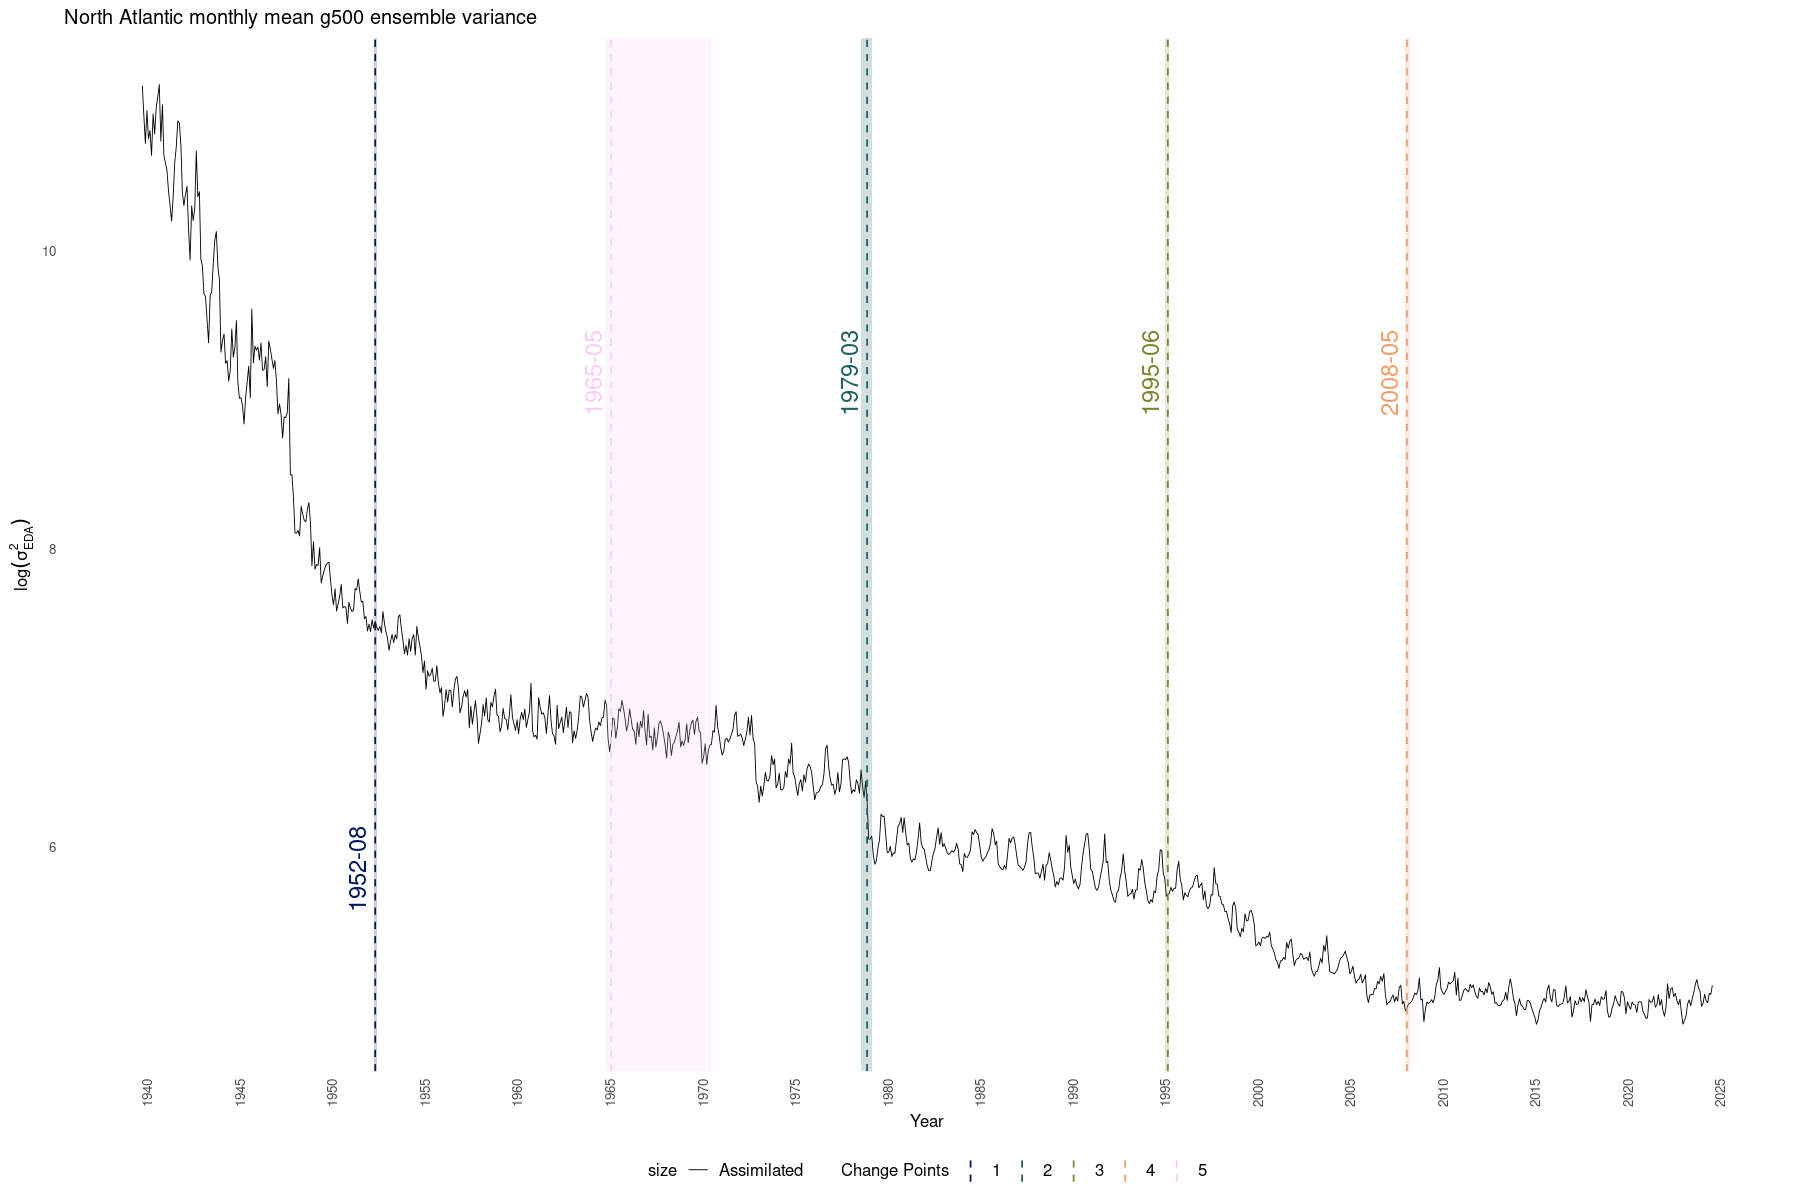

pdf 
  2

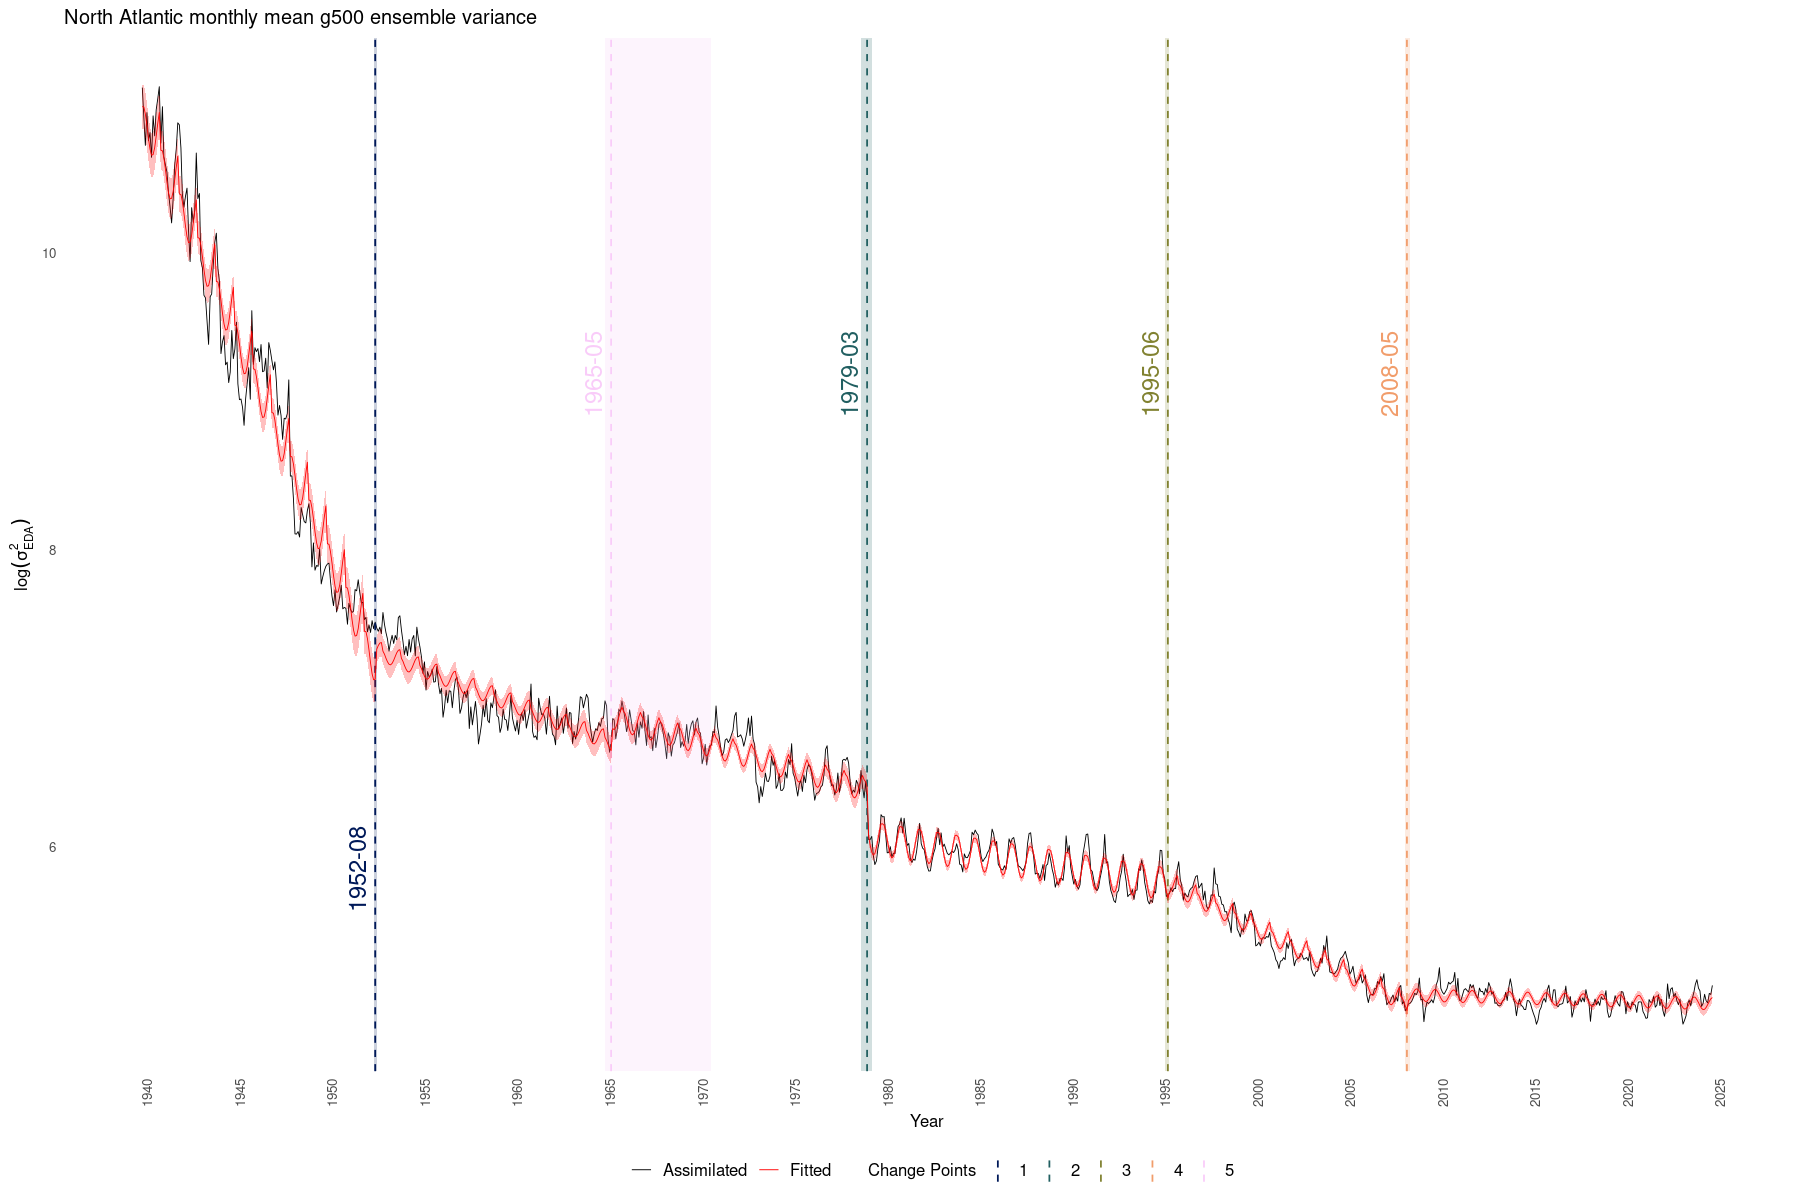

pdf 
  2

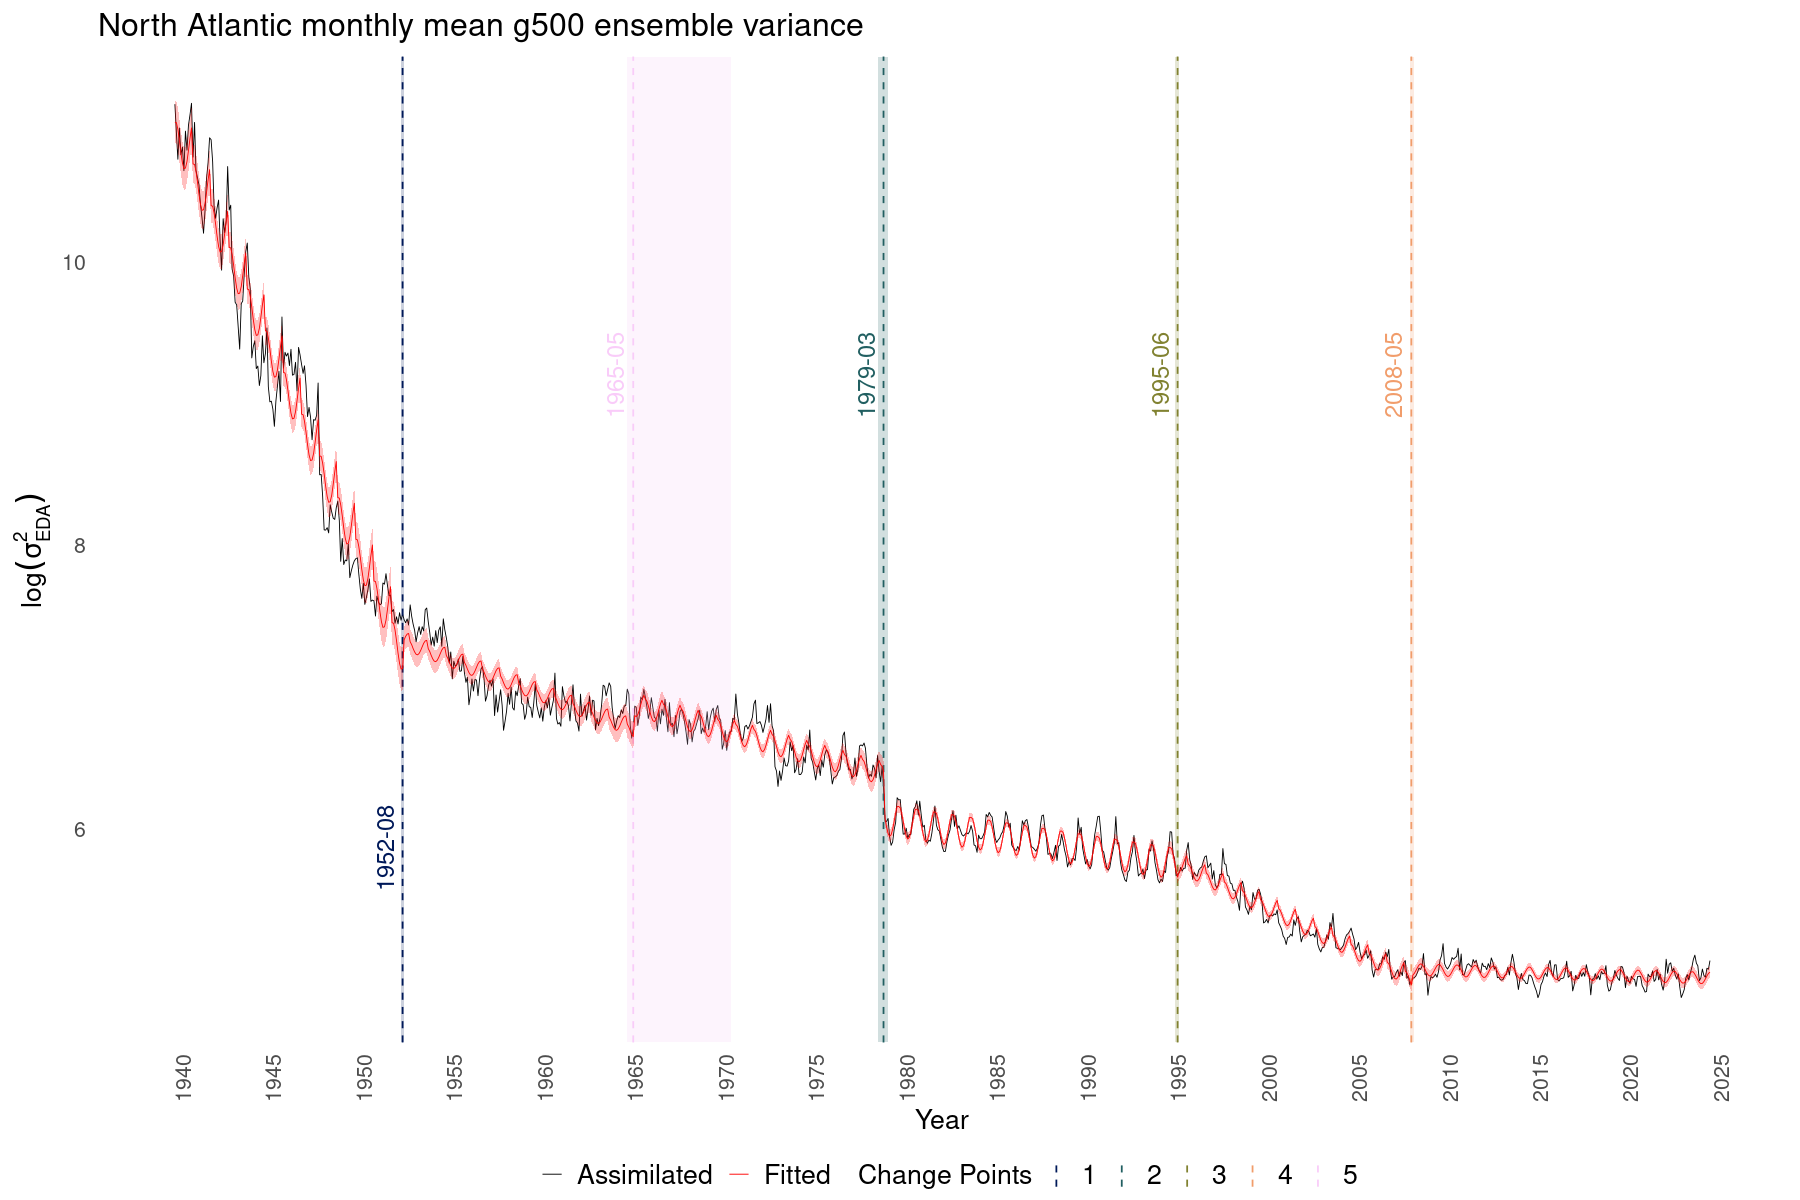

In [15]:
p <- plot_change_points(
    data = combined_dataset,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)
p

fitted_layers <- add_fitted_line_ci(lmod_seas_monthly, combined_dataset)
for (layer in fitted_layers) {
    p <- p + layer
}

# Optional: Combine the legends for size and linetype into one "Data" legend
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
)

p

save_plot(p, "ChangePoints.pdf")

p <- p + THEME_PUB_LARGE
p
save_plot(p, "ChangePointsLarge.pdf", width = 9.5, height = 4.25)


### Have a look at the seasonal cycles for each segment and for the whole period
- We want uncertainties for amplitude and phase. 
- We want to use a parametric bootstrap for this (draw parameters from the betas according to their mean and covariance estimates)
- This is only ok if the residuals are approximately normally distributed, do we need to check

Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 

	Shapiro-Wilk normality test

data:  std_resid
W = 0.99837, p-value = 0.4554



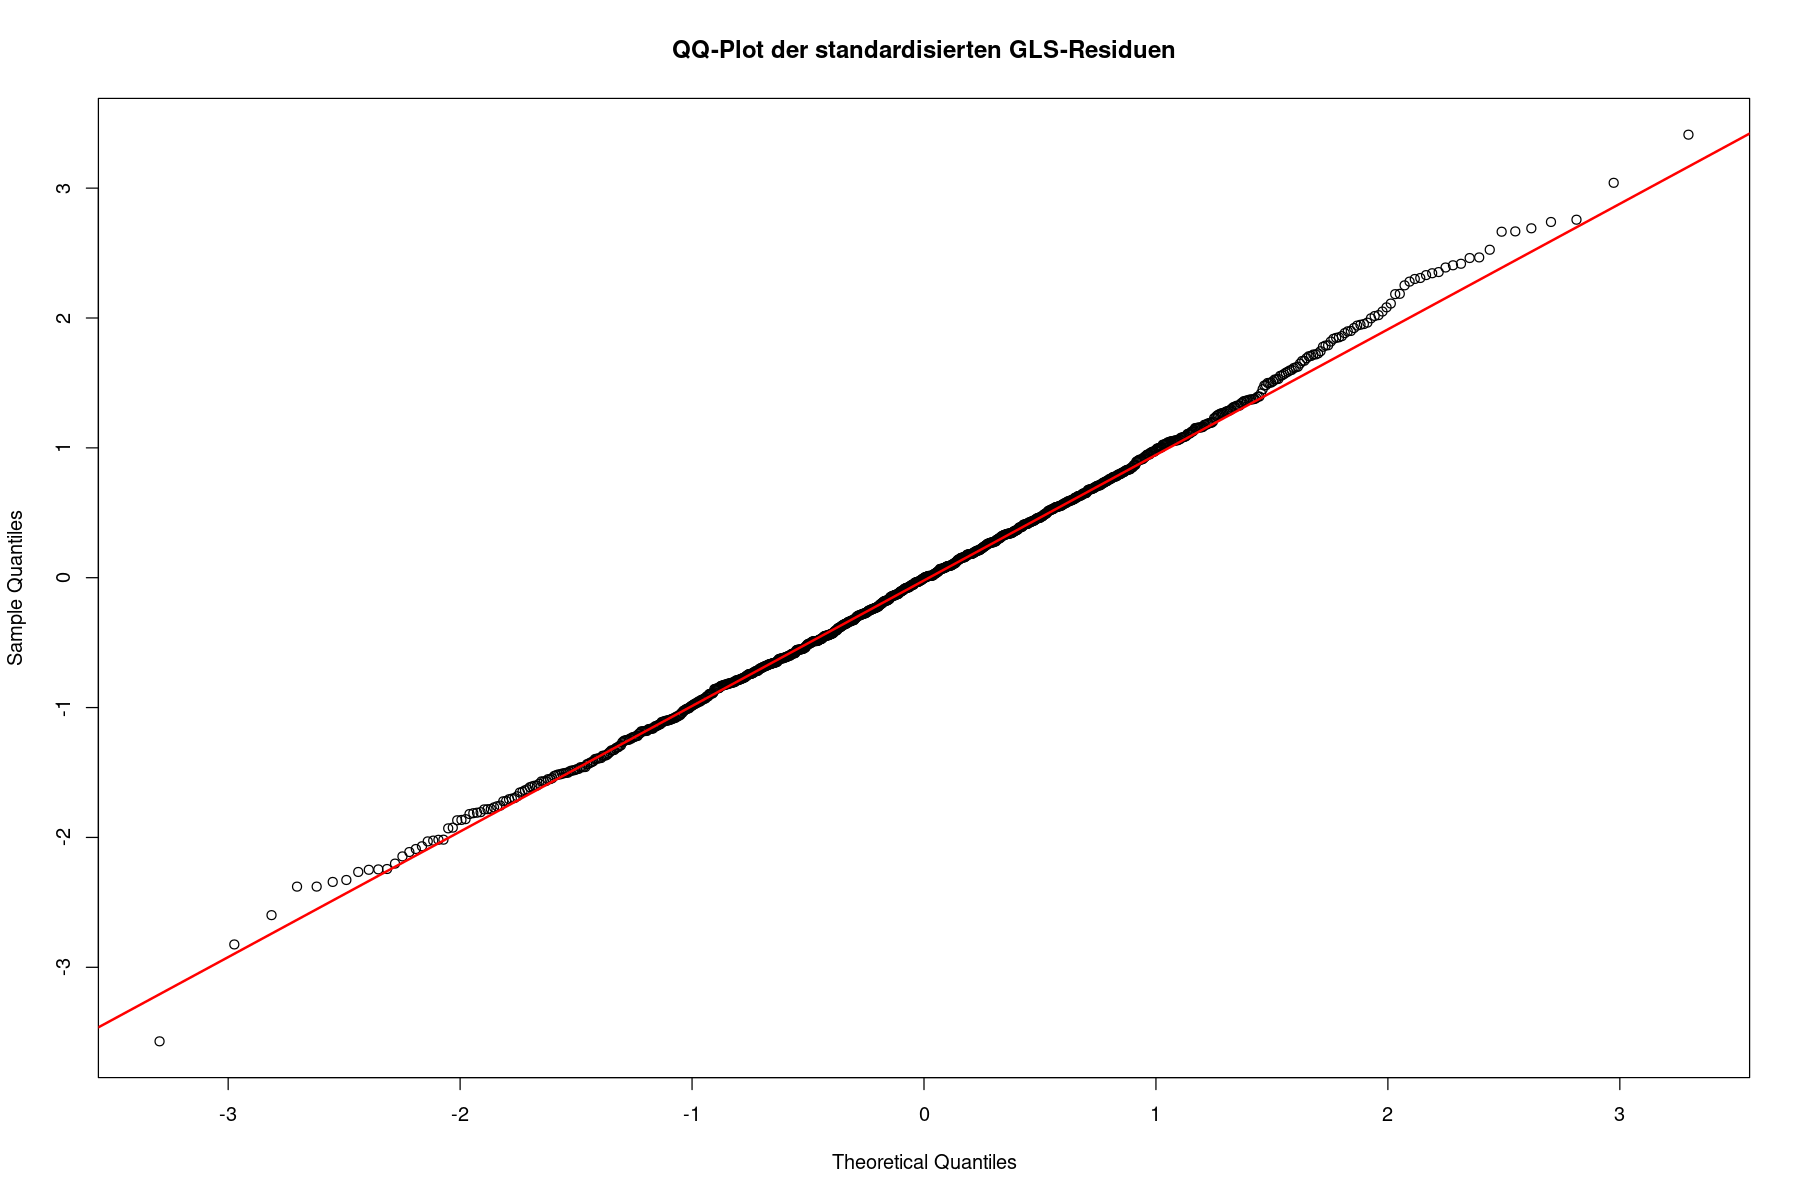

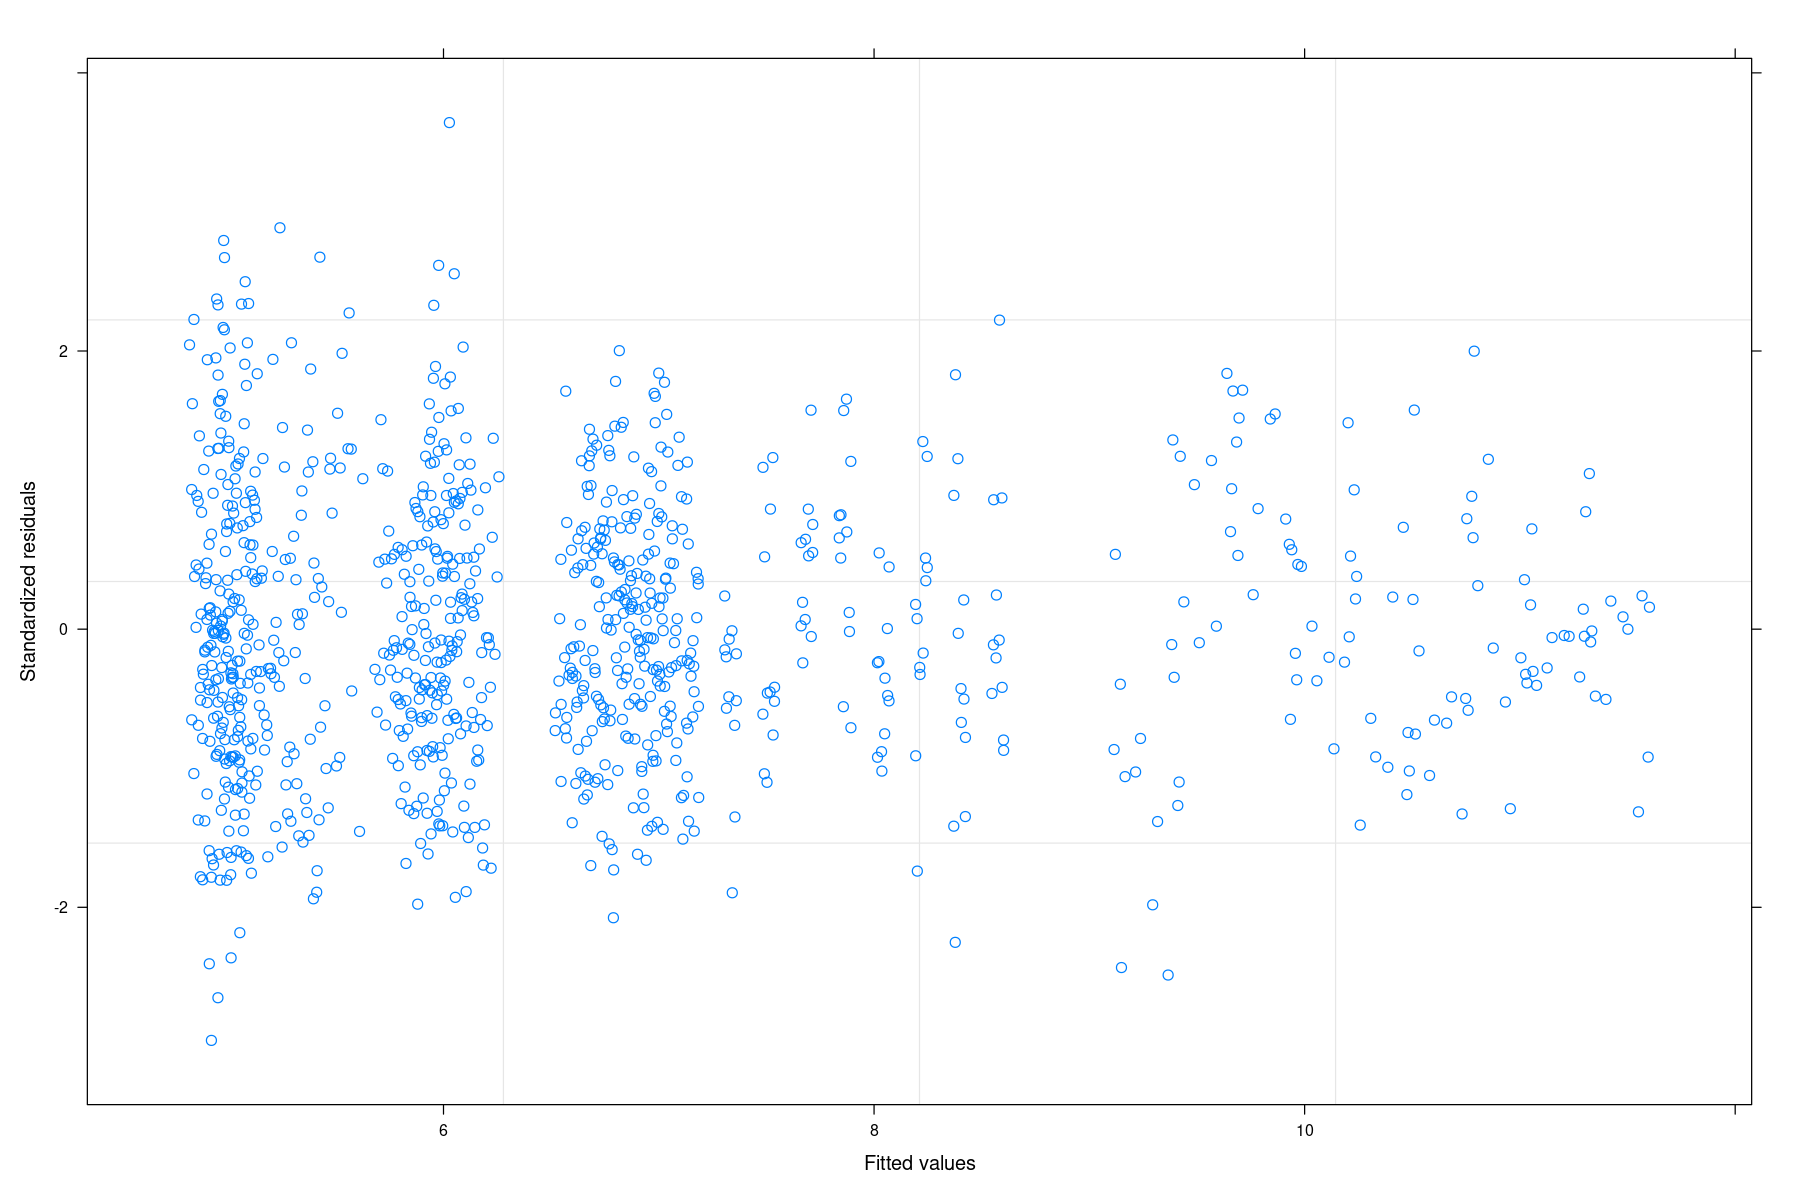

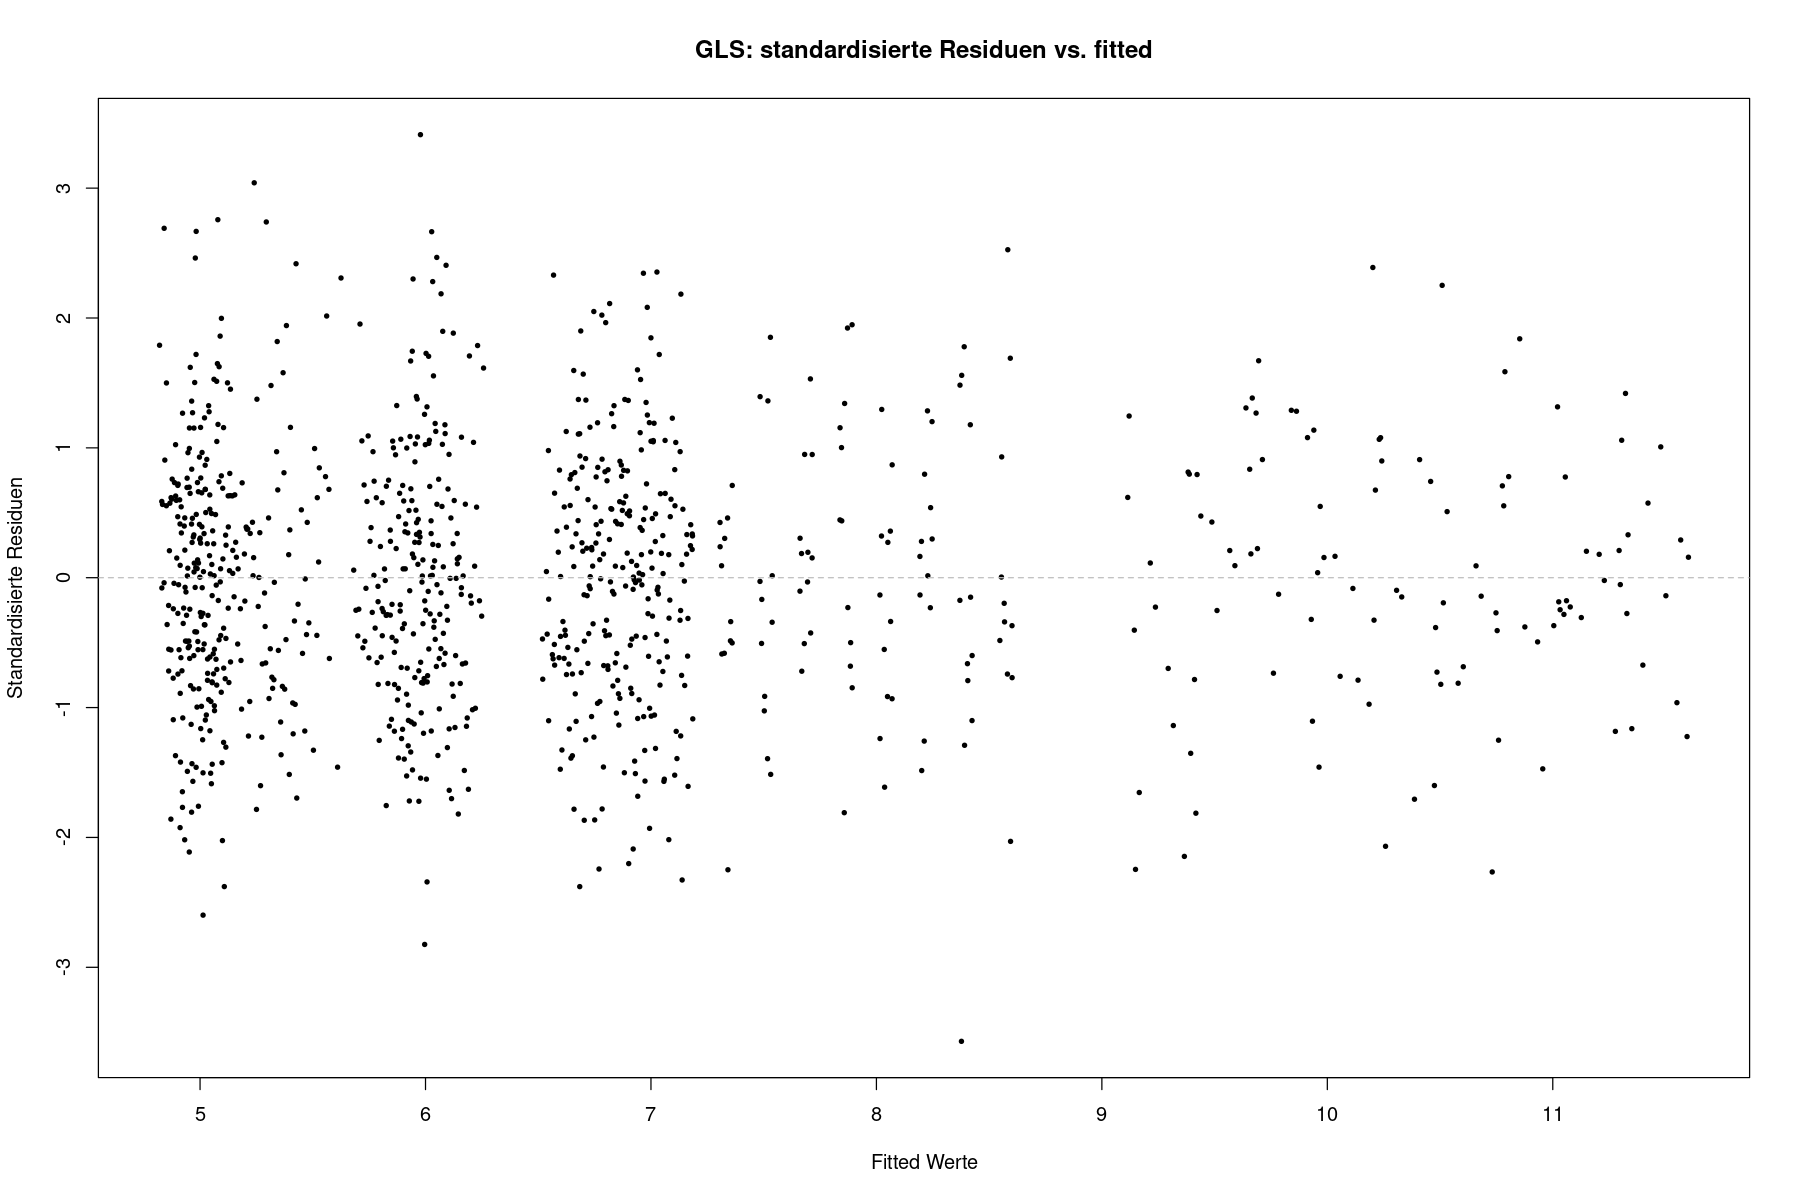

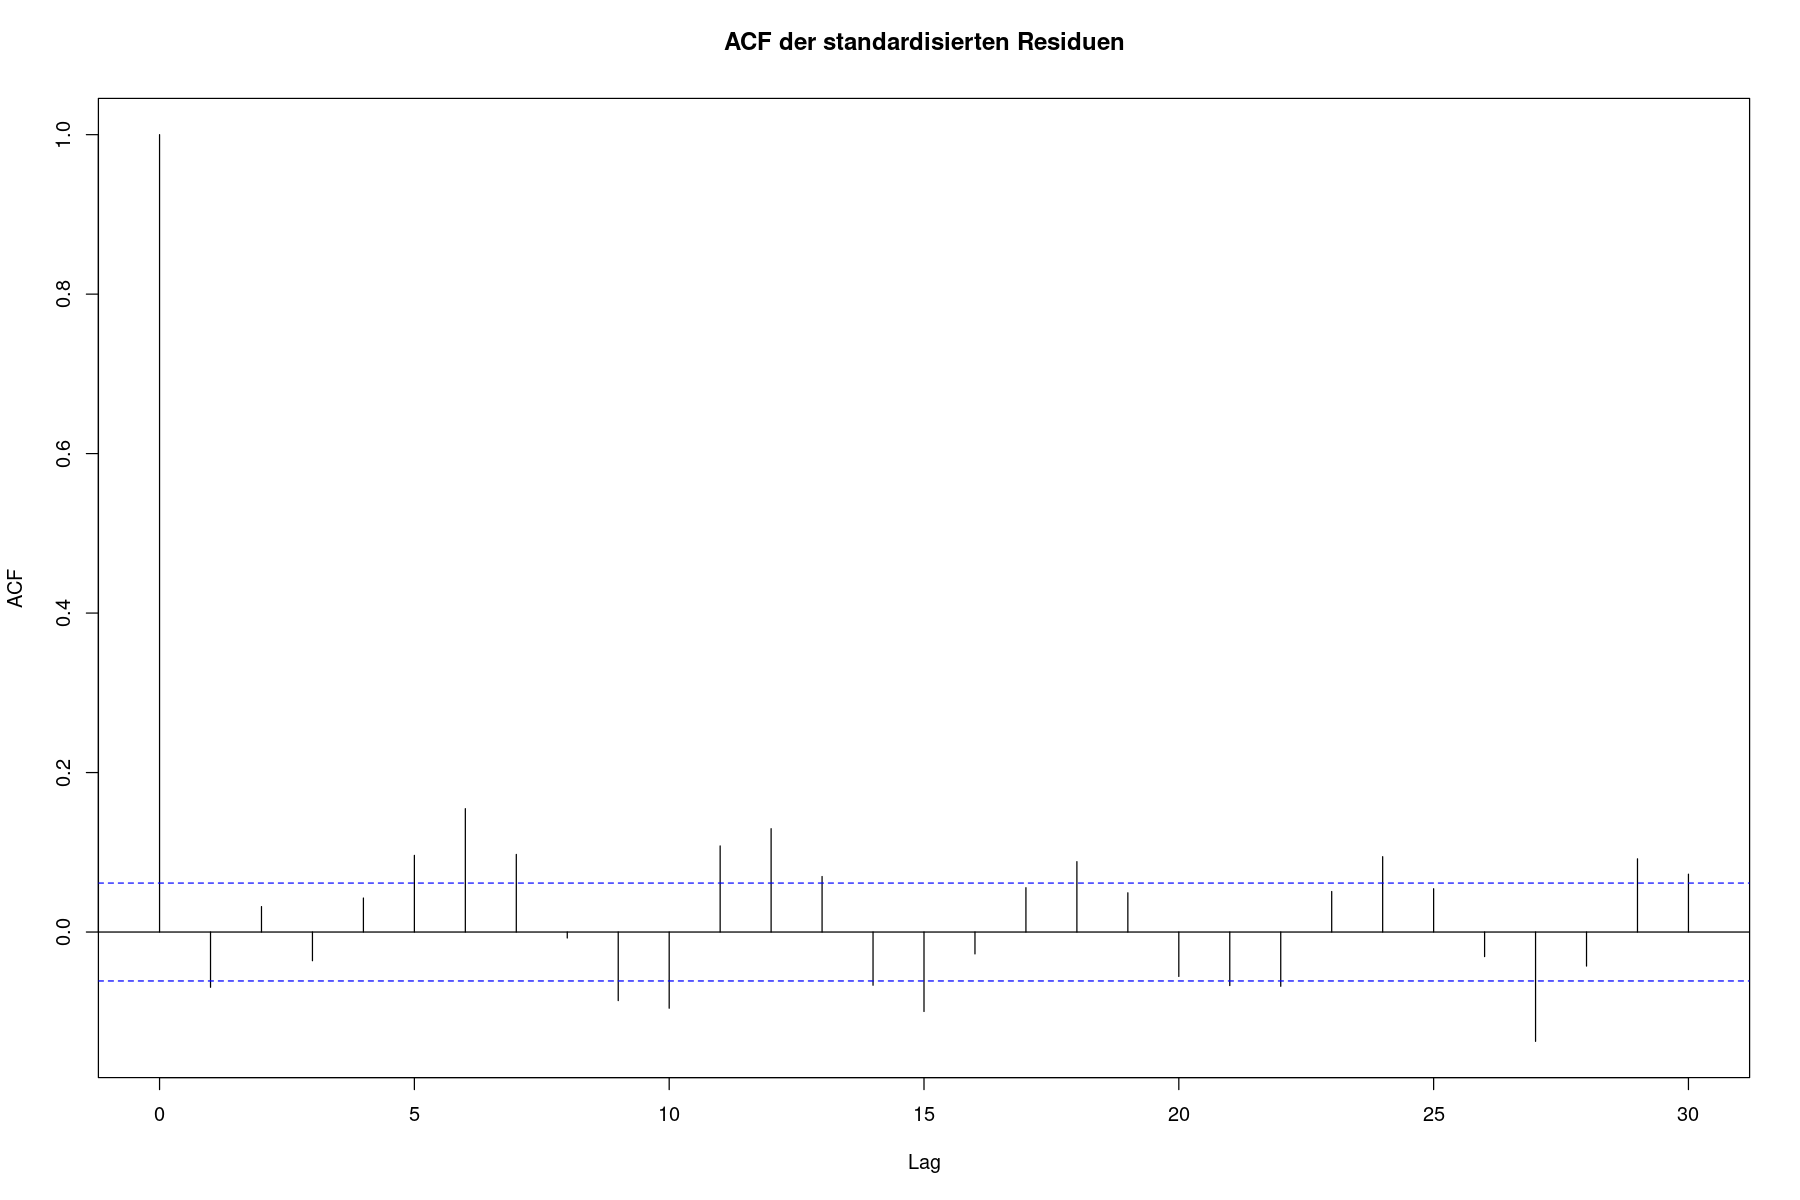

In [53]:
std_resid <- resid(lmod_seas_monthly, type = "normalized")
# “normalized” residuum sind so skaliert, dass sie etwa std-norm verteilt sein sollten.

# 2a) Shapiro-Wilk-Test auf Normalität der standardisierten Residuen
shapiro_std <- shapiro.test(std_resid)
cat("Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 \n")
print(shapiro_std)
par(bg = "white")
qqnorm(std_resid, main = "QQ-Plot der standardisierten GLS-Residuen")
qqline(std_resid, col = "red", lwd = 2)
plot(lmod_seas_monthly)
acf(std_resid, main = "ACF der standardisierten Residuen")


pdf 
  2

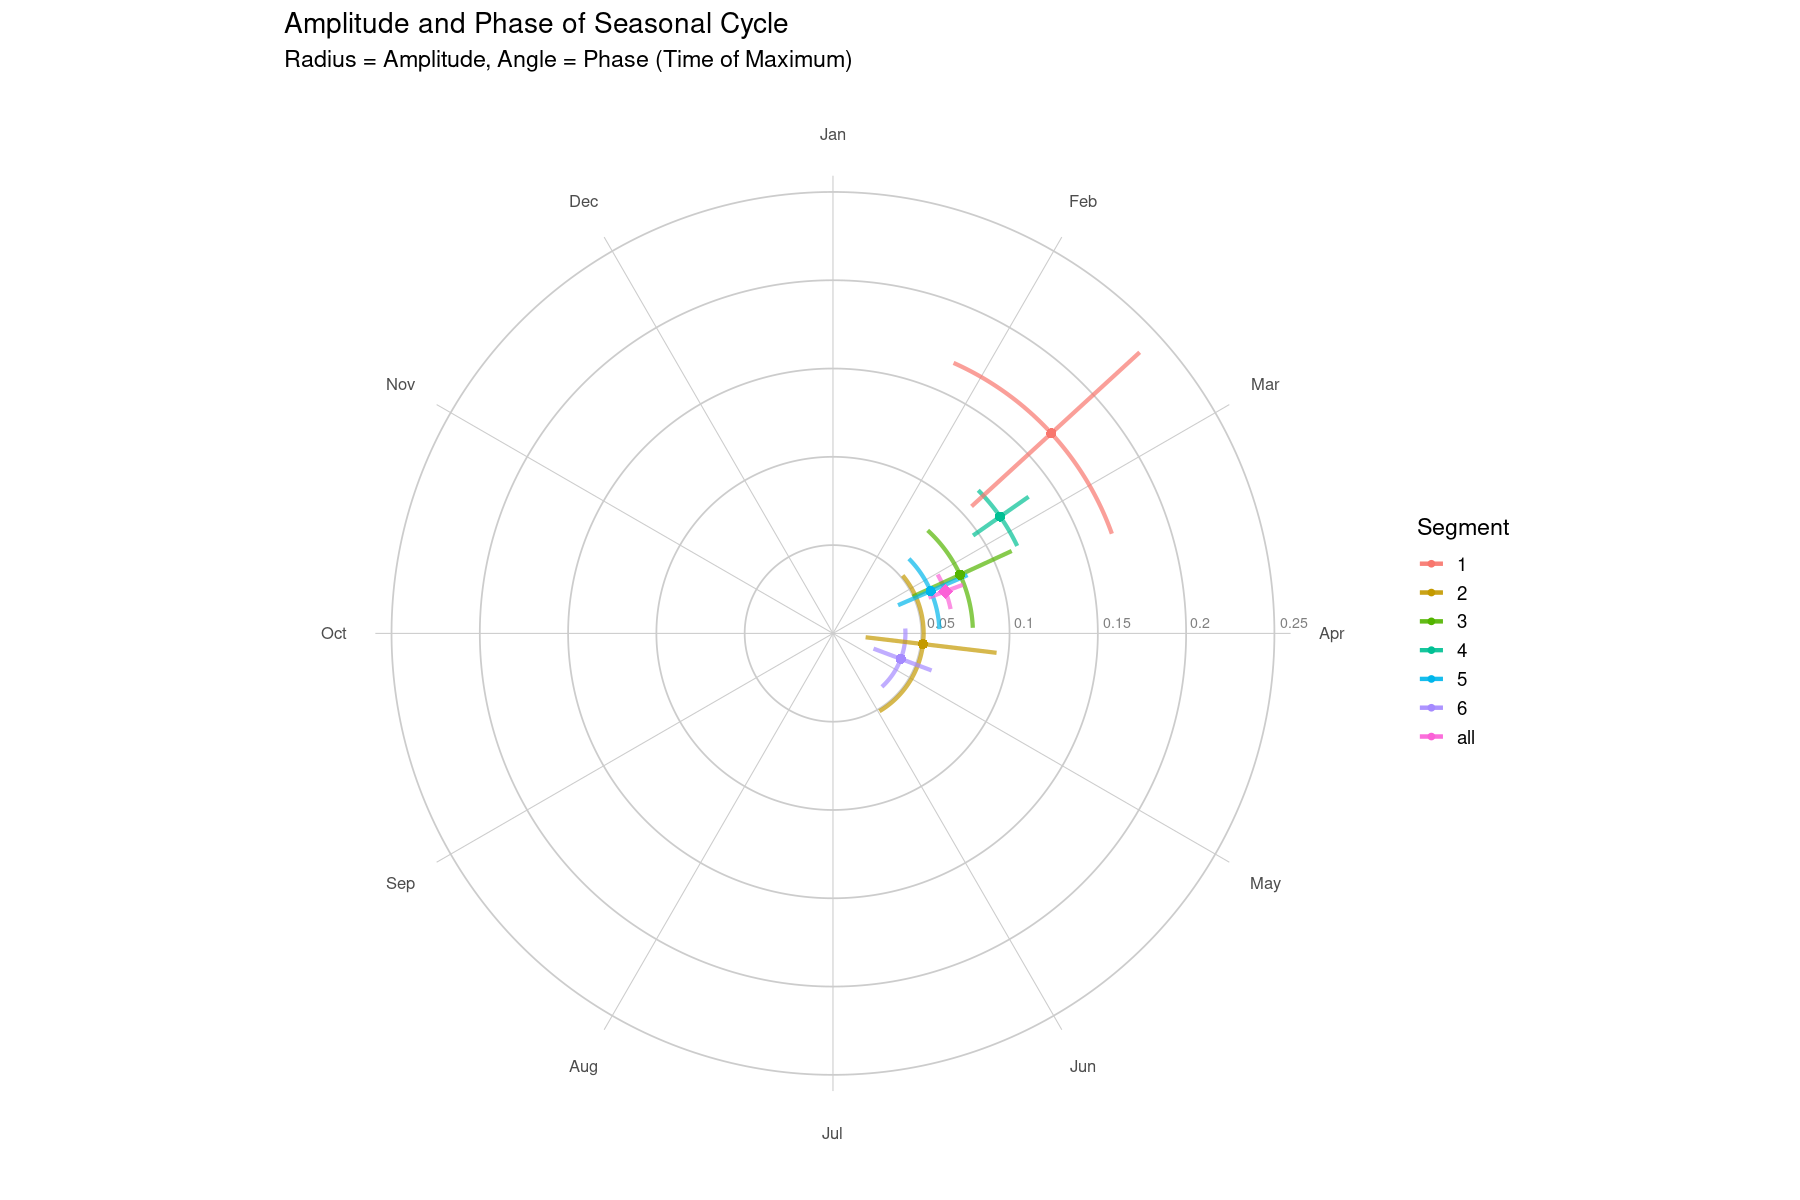

In [17]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Helper: Normiere Winkel auf [0, 2π)
# ─────────────────────────────────────────────────────────────────────────────
to_positive <- function(angle) {
    a <- angle %% (2 * pi)
    ifelse(a < 0, a + 2 * pi, a)
}

# ─────────────────────────────────────────────────────────────────────────────
# 2. Ermittle kleinstes 95%-Intervall auf dem Kreis (kürzeste Bogensegment)
# ─────────────────────────────────────────────────────────────────────────────
circular_CI <- function(angles, alpha = 0.05) {
    # Normiere auf [0, 2π)
    ang <- to_positive(angles)
    n <- length(ang)
    m <- floor((1 - alpha) * n)
    # Sortiere
    ang_sorted <- sort(ang)
    # Erweitere zweifach um 2π für Wrap-Around-Suche
    ang_ext <- c(ang_sorted, ang_sorted + 2 * pi)
    # Finde Fenster der Größe m mit minimalem Bogen
    ends <- ang_ext[(m + 1):(length(ang_ext))]
    starts <- ang_ext[1:(length(ang_ext) - m)]
    widths <- ends - starts
    idx_min <- which.min(widths)
    lower <- starts[idx_min] %% (2 * pi)
    upper <- ends[idx_min] %% (2 * pi)
    list(lower = lower, upper = upper)
}

# ─────────────────────────────────────────────────────────────────────────────
# 3. Bootstrap‐CI‐Berechnung für Amplitude & Phase
# ─────────────────────────────────────────────────────────────────────────────
get_seasonal_CI <- function(gls_model, B = 5000, alpha = 0.05) {
    beta_all <- coef(gls_model)
    varBeta <- gls_model$varBeta
    fe_names <- names(beta_all)

    # Look for sin/cos patterns - handle both segment-specific and global
    idx_sin <- grep("sin_mon", fe_names)
    idx_cos <- grep("cos_mon", fe_names)

    if (length(idx_sin) == 0 || length(idx_cos) == 0) {
        return(tibble())
    }

    # Extract segment names or use "seasonal_model" for global
    seg_sin <- ifelse(grepl(":", fe_names[idx_sin]),
        sub(":sin_mon$", "", fe_names[idx_sin]),
        "seasonal_model"
    )
    seg_cos <- ifelse(grepl(":", fe_names[idx_cos]),
        sub(":cos_mon$", "", fe_names[idx_cos]),
        "seasonal_model"
    )

    segments <- intersect(seg_sin, seg_cos)
    if (length(segments) == 0) {
        return(tibble())
    }

    idx_sin_matched <- idx_sin[match(segments, seg_sin)]
    idx_cos_matched <- idx_cos[match(segments, seg_cos)]

    beta_sin_hat <- beta_all[idx_sin_matched]
    beta_cos_hat <- beta_all[idx_cos_matched]
    R_hat <- sqrt(beta_sin_hat^2 + beta_cos_hat^2)
    phi_hat <- atan2(beta_sin_hat, beta_cos_hat)
    phi_hat_pos <- to_positive(phi_hat)

    Sigma_sc <- varBeta[c(idx_sin_matched, idx_cos_matched), c(idx_sin_matched, idx_cos_matched)]
    mu_sc <- beta_all[c(idx_sin_matched, idx_cos_matched)]

    if (nrow(Sigma_sc) == 0) {
        return(tibble())
    }

    BSim <- MASS::mvrnorm(n = B, mu = mu_sc, Sigma = Sigma_sc)
    S <- length(segments)

    A_boot <- sqrt(BSim[, 1:S, drop = FALSE]^2 + BSim[, (S + 1):(2 * S), drop = FALSE]^2)
    phi_boot_raw <- atan2(BSim[, 1:S, drop = FALSE], BSim[, (S + 1):(2 * S), drop = FALSE])

    CI_R <- apply(A_boot, 2, function(x) quantile(x, probs = c(alpha / 2, 1 - alpha / 2)))
    CI_phi <- map_dfr(seq_len(S), function(j) {
        cci <- circular_CI(phi_boot_raw[, j], alpha = alpha)
        tibble(phi_lwr = cci$lower, phi_upr = cci$upper)
    })

    tibble(
        segment = segments,
        R = R_hat, phi = phi_hat_pos,
        R_lwr = CI_R[1, ], R_upr = CI_R[2, ]
    ) %>%
        bind_cols(CI_phi) %>%
        mutate(
            x = R * cos(phi), y = R * sin(phi),
            x_lwr = R_lwr * cos(phi), y_lwr = R_lwr * sin(phi),
            x_upr = R_upr * cos(phi), y_upr = R_upr * sin(phi),
            segment_clean = case_when(
                segment == "seasonal_model" ~ "all",
                grepl("^segment", segment) ~ gsub("segment", "", segment),
                TRUE ~ segment
            )
        )
}

# ─────────────────────────────────────────────────────────────────────────────
# 4. Hilfsfunktionen für den Polar‐Plot
# ─────────────────────────────────────────────────────────────────────────────
make_circle <- function(r, n = 360) {
    tibble(
        theta = seq(0, 2 * pi, length.out = n),
        x = r * cos(theta),
        y = r * sin(theta),
        radius = r # Add radius identifier for grouping
    )
}

make_arc_segments <- function(df_ci, n_points = 100) {
    map_df(seq_len(nrow(df_ci)), function(i) {
        R_seg <- df_ci$R[i]
        angle_lo <- df_ci$phi_lwr[i]
        angle_hi <- df_ci$phi_upr[i]
        # Handle wrap-around
        if (angle_hi < angle_lo) angle_hi <- angle_hi + 2 * pi
        angles <- seq(angle_lo, angle_hi, length.out = n_points)
        tibble(
            segment_clean = df_ci$segment_clean[i], # Use cleaned segment names
            x_arc = R_seg * cos(angles),
            y_arc = R_seg * sin(angles),
            id = i
        )
    })
}

# Fixed grid function - creates concentric circles
make_grid <- function(R_max, n_levels = 4) {
    levels <- pretty(c(0, R_max), n = n_levels)
    levels <- levels[levels > 0] # Remove zero level
    map_df(levels, make_circle)
}

# Simplified month lines - one line per month
make_month_lines <- function(R_max) {
    # Start from January at top (π/2) and go clockwise
    month_angles <- seq(pi / 2, pi / 2 - 2 * pi, length.out = 13)[1:12]
    month_labels <- c(
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    )
    tibble(
        angle   = month_angles,
        x       = 0,
        y       = 0,
        xend    = R_max * 1.1 * cos(angle), # Extend slightly beyond max radius
        yend    = R_max * 1.1 * sin(angle),
        label_x = R_max * 1.2 * cos(angle), # Place labels further out
        label_y = R_max * 1.2 * sin(angle),
        label   = month_labels
    )
}

# Add function to create radius labels
make_radius_labels <- function(R_max, n_levels = 4) {
    levels <- pretty(c(0, R_max), n = n_levels)
    levels <- levels[levels > 0] # Remove zero level
    tibble(
        x = levels,
        y = 0,
        label = as.character(round(levels, 2))
    )
}

# ─────────────────────────────────────────────────────────────────────────────
# 5. Plot‐Funktion
# ─────────────────────────────────────────────────────────────────────────────
plot_seasonal_polar <- function(df_ci) {
    R_max <- max(df_ci$R_upr)
    grid_circles <- make_grid(R_max)
    month_lines <- make_month_lines(R_max)
    radius_labels <- make_radius_labels(R_max)
    arc_segments <- make_arc_segments(df_ci)

    ggplot() +
        # Concentric circles for radius grid
        geom_path(
            data = grid_circles, aes(x = x, y = y, group = radius),
            color = "grey80", linewidth = 0.5
        ) +
        # Month lines (radial lines)
        geom_segment(
            data = month_lines, aes(x = x, y = y, xend = xend, yend = yend),
            color = "grey80", linewidth = 0.3
        ) +
        # Month labels
        geom_text(
            data = month_lines, aes(x = label_x, y = label_y, label = label),
            size = 3.5, color = "grey30"
        ) +
        # Radius labels
        geom_text(
            data = radius_labels, aes(x = x, y = y, label = label),
            size = 3, color = "grey50", hjust = -0.2, vjust = -0.5
        ) +
        # Confidence intervals as arcs
        geom_path(
            data = arc_segments, aes(x = x_arc, y = y_arc, group = id, color = segment_clean),
            linewidth = 1.2, alpha = 0.7
        ) +
        # Radial confidence intervals
        geom_segment(
            data = df_ci, aes(x = x_lwr, y = y_lwr, xend = x_upr, yend = y_upr, color = segment_clean),
            linewidth = 1.2, alpha = 0.7
        ) +
        # Point estimates with different shapes/sizes for "all" vs individual segments
        geom_point(data = df_ci, aes(
            x = x, y = y, color = segment_clean,
            shape = segment_clean == "all",
            size = segment_clean == "all"
        )) +
        scale_size_manual(values = c("TRUE" = 4, "FALSE" = 2.5), guide = "none") +
        scale_shape_manual(values = c("TRUE" = 18, "FALSE" = 16), guide = "none") + # Diamond for "all", circle for segments
        coord_equal() +
        theme_minimal(base_size = 14) +
        theme(
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid = element_blank(),
            panel.background = element_blank(),
            plot.background = element_blank(),
            legend.position = "right"
        ) +
        labs(
            title = "Amplitude and Phase of Seasonal Cycle",
            subtitle = "Radius = Amplitude, Angle = Phase (Time of Maximum)",
            color = "Segment"
        )
}

# ─────────────────────────────────────────────────────────────────────────────
# 6. Beispielaufruf - combine both models
# ─────────────────────────────────────────────────────────────────────────────
# Get CIs from both models and combine them
df_ci_segments <- get_seasonal_CI(lmod_seas_monthly, B = N_PERM)
df_ci_seasonal <- get_seasonal_CI(seasonal_model, B = N_PERM)

# Only combine if both have results
df_ci_combined <- bind_rows(
    df_ci_segments,
    df_ci_seasonal
) %>%
    filter(nrow(.) > 0) # Remove empty results

if (nrow(df_ci_combined) > 0) {
    p <- plot_seasonal_polar(df_ci_combined)
} else {
    cat("No seasonal parameters found in the models. Please check parameter names.\n")
    cat("Expected parameter names containing 'sin_mon' and 'cos_mon'.\n")
    cat("Segmented model parameters:", paste(names(coef(lmod_seas_monthly)), collapse = ", "), "\n")
    cat("Seasonal model parameters:", paste(names(coef(seasonal_model)), collapse = ", "), "\n")
}

p
save_plot(p, "SeasonalCyclePolarLarge.pdf", width = 6, height = 5)


# Watch our for Autocorrelation!
**All models fitted exhibit autocorrelation to a significant degree. This comes as no surprise, but demands choosing ARIMA over ordinary least squares**

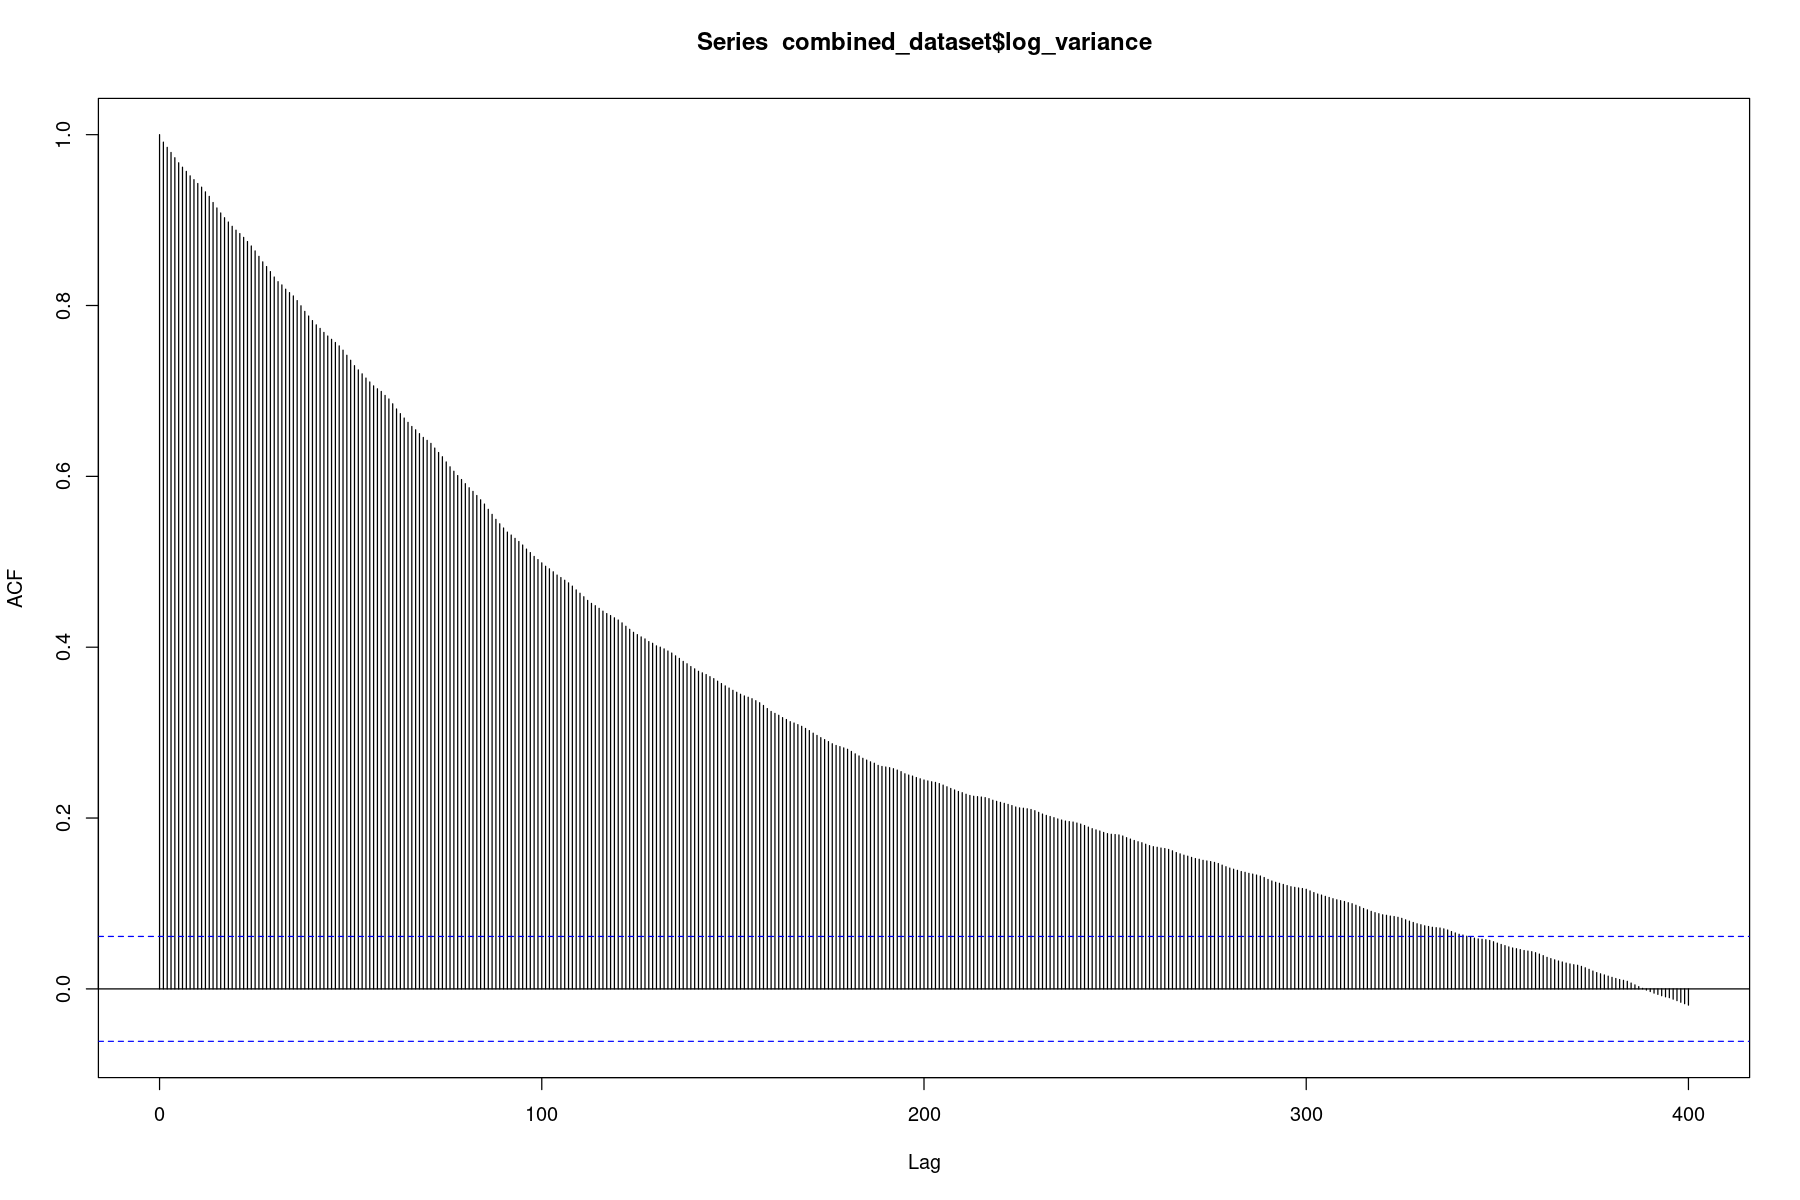

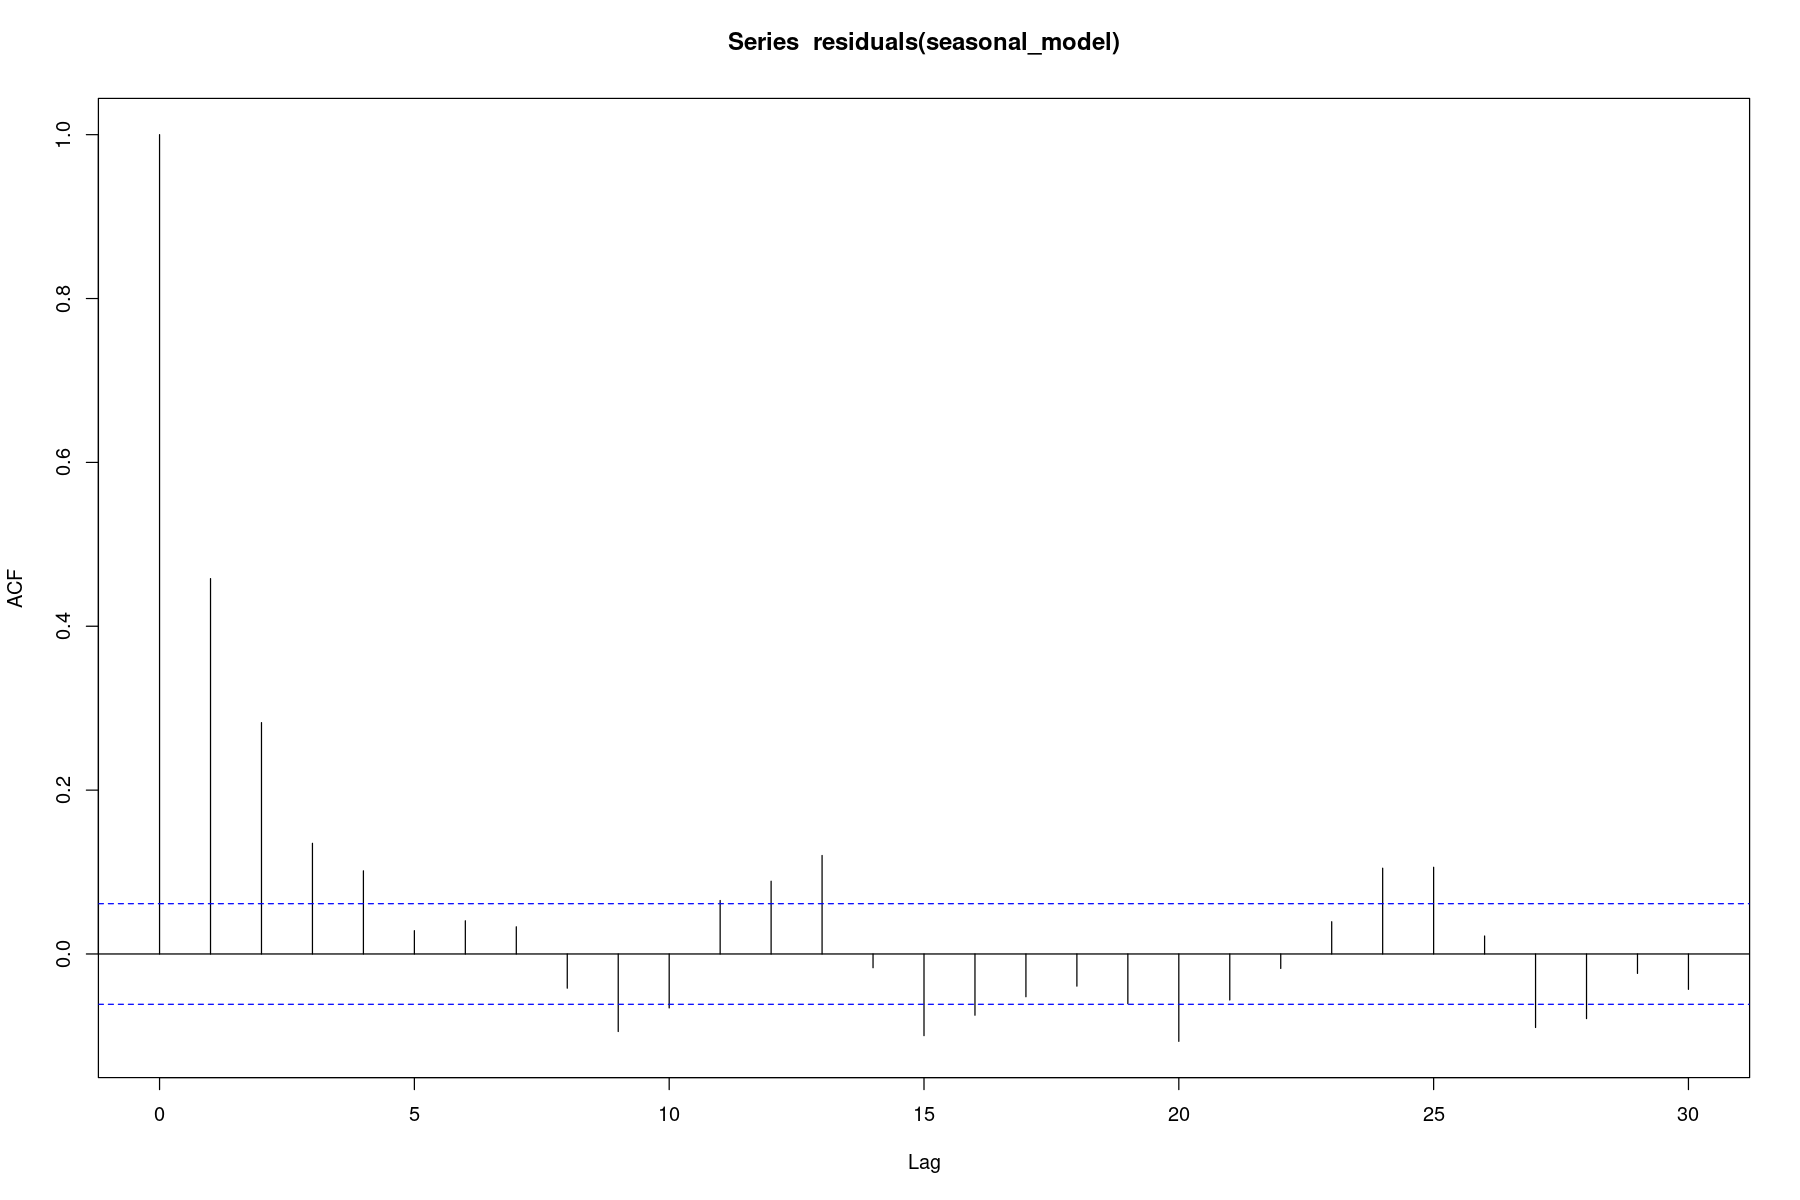

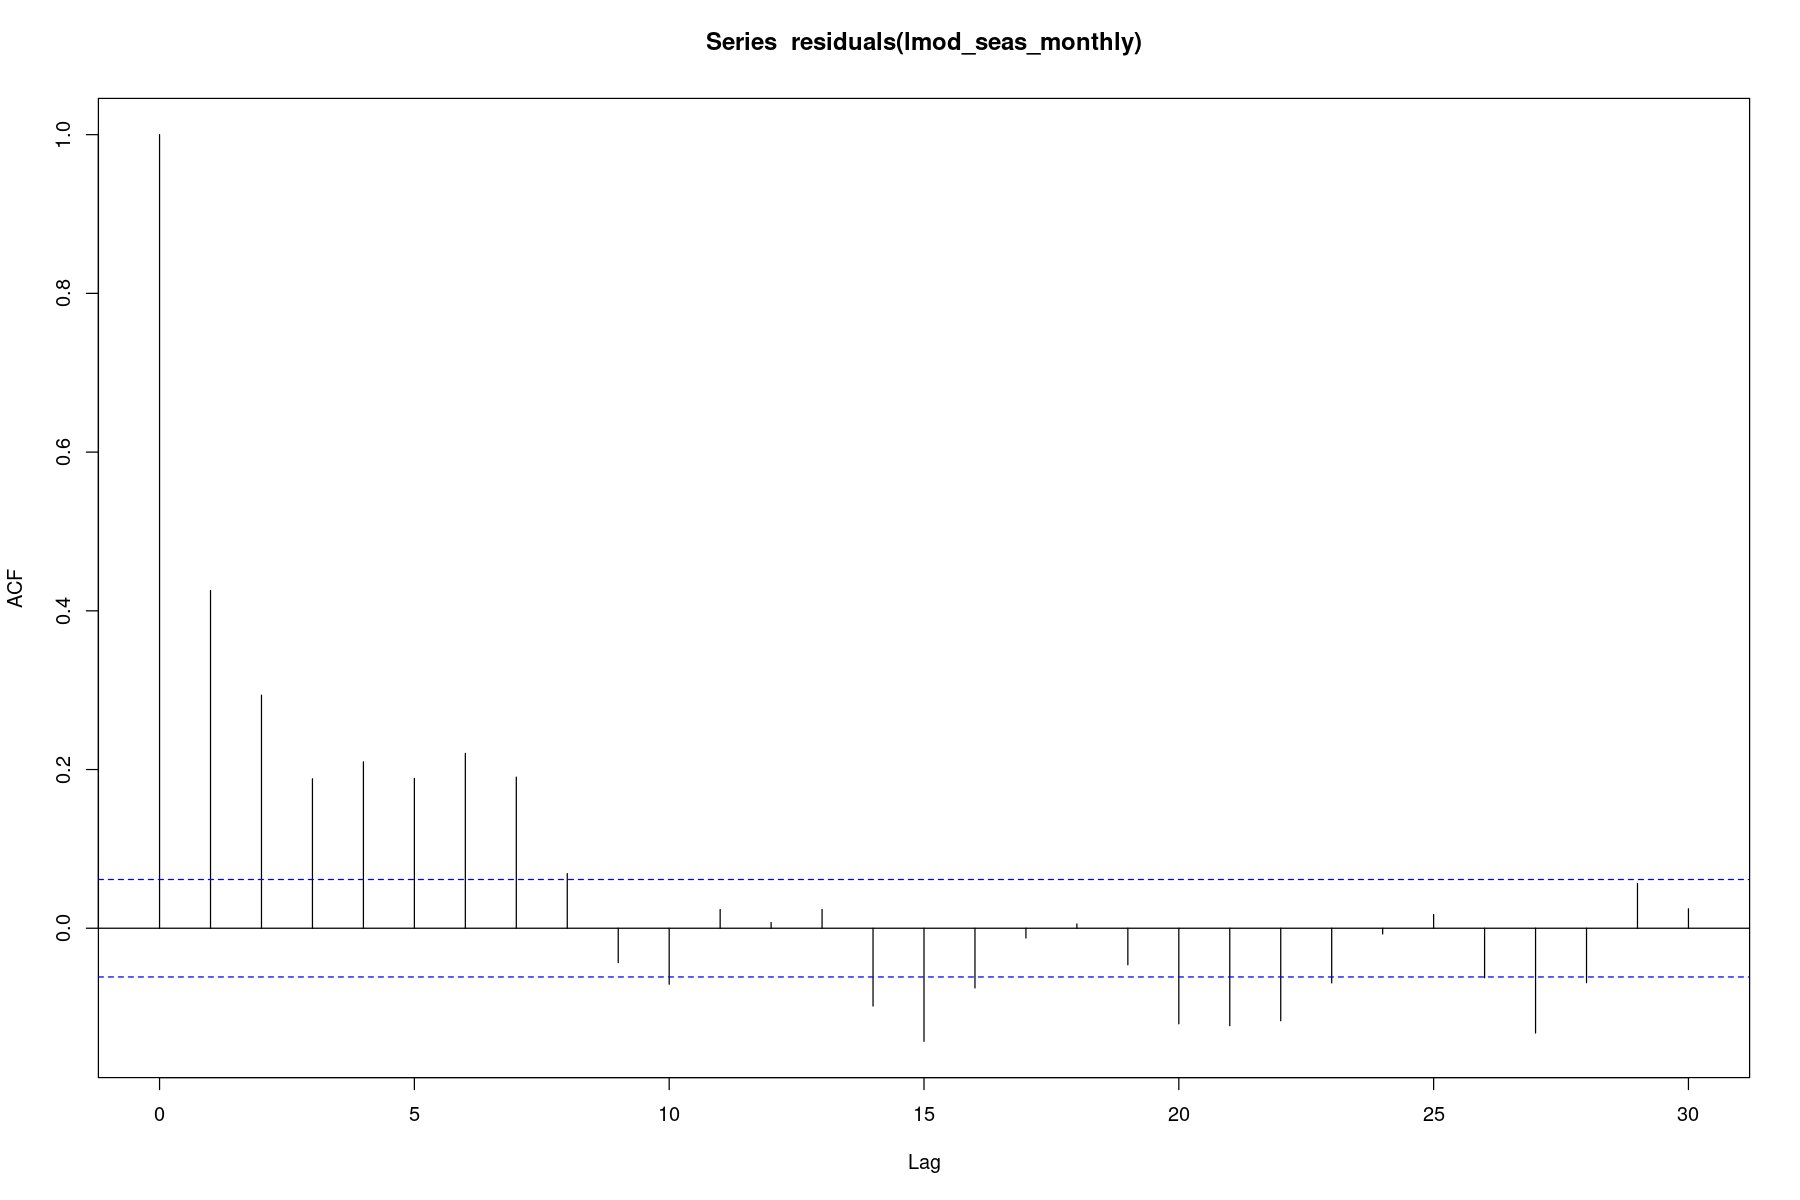

In [ ]:
par(bg = "white")
plot(acf(combined_dataset$log_variance, lag.max = 400))
plot(acf(residuals(seasonal_model), lag.max = 30))
plot(acf(residuals(lmod_seas_monthly), lag.max = 30))
